In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import visualization
import datahandler

In [2]:
participant_code = 'J4X1T0D2'
load_state_data = False
data_path = './participant data/'
trimmed_data, sections, gender, age, calmFirst = datahandler.load_participant(participant_code, data_path, load_state_data)

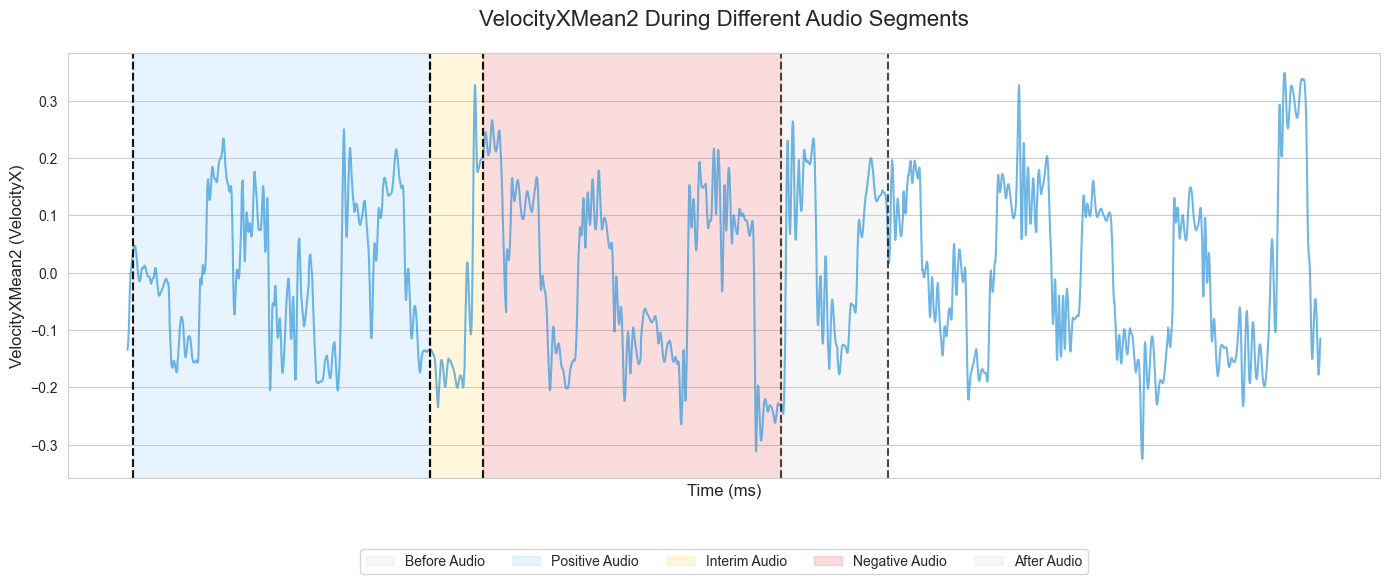

In [3]:
trimmed_data['VelocityXMean2'] = trimmed_data['VelocityX'].rolling(window=10000, min_periods=1000).mean()

visualization.plot_column(trimmed_data, 'VelocityXMean2', 'VelocityX', sections=sections)


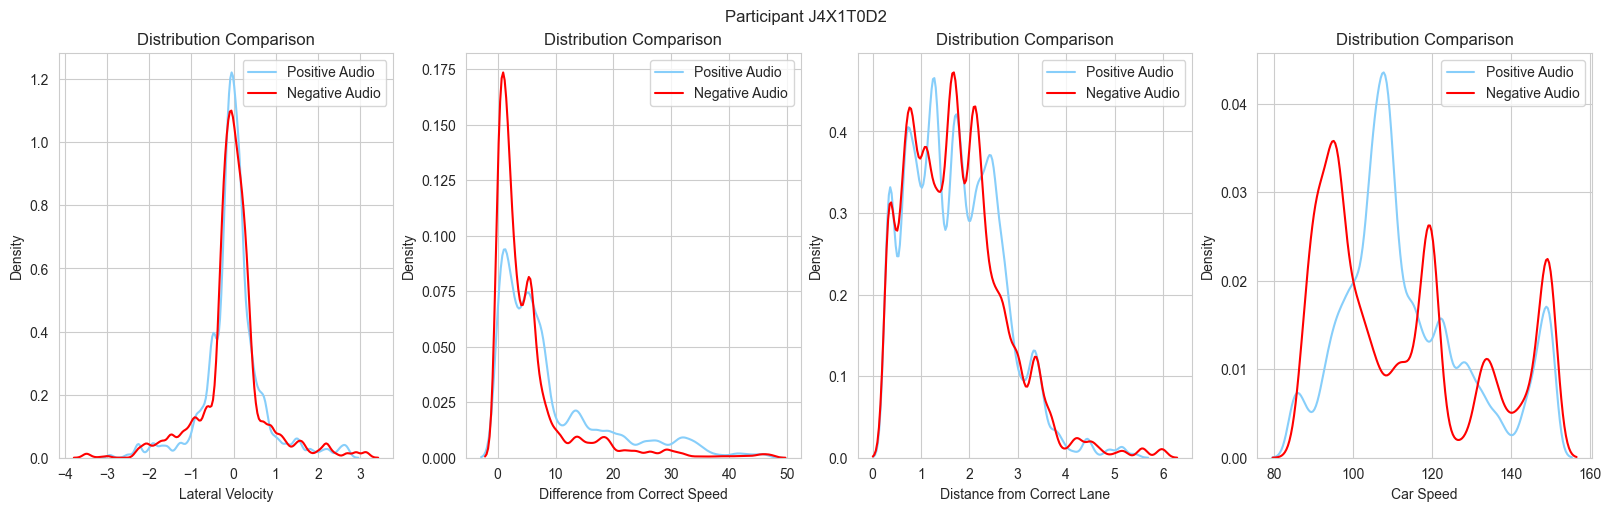

In [4]:
_ = visualization.compare_perf_kdes(participant_code, trimmed_data, sections=sections)


### Analyze distributions

In [5]:
datahandler.get_statistics(trimmed_data, sections=sections)

(np.float64(1.721801584985443),
 np.float64(0.9327492875572724),
 np.float64(2.757911762590358),
 np.float64(1.7069149348398658),
 np.float64(0.9703997623176227),
 np.float64(3.2058648320120624))

In [6]:
import os

def get_all_stats(remove_outliers=None, drop_gender=None, drop_order=None):
    for root, dirs, files in os.walk(data_path):
        identifiers = [f.replace('.csv','') for f in files if f != "W1D9N0B8.csv" and f != 'M3A2H7Q4.csv']
    print(identifiers)

    intense_stats = []
    calm_stats = []
    for id in identifiers:
        load_state_data = False

        try:
            trimmed_data, sections, gender, age, calmFirst = datahandler.load_participant(id, data_path, load_state_data, remove_outliers=remove_outliers)
            print(f'{id} OK')
            calmFirst = "PN" if calmFirst else "NP"
            if gender == drop_gender:
                print(f'Skipping {id} cause of gender')
                continue
            if drop_order and calmFirst == drop_order:
                print(f'Skipping {id} cause of order')
                continue
        except Exception as e:
            print(f'{id} FAIL')
            # print(e)
            continue
        
        
        trimmed_data['VelocityXMean'] = trimmed_data['VelocityX'].rolling(window=10000).mean()
        trimmed_data['DistanceToTargetPositionStd'] = trimmed_data['DistanceToTargetPosition'].rolling(window=10000).std()
        trimmed_data['DistanceToTargetSpeed_Mean'] = trimmed_data['DistanceToTargetSpeed'].rolling(window=10000).mean()
        trimmed_data['VelocityX_Mean'] = trimmed_data['VelocityX'].rolling(window=10000).mean()
        
        visualization.compare_perf_kdes(id, trimmed_data, sections=sections)

        pairs = [
        ('VelocityX', 'Lateral Velocity'),
        ('DistanceToTargetSpeed', 'Difference to Correct Speed'),
        ('DistanceToTargetPosition','Distance to Correct Lane'),
        ('CarSpeed', 'Car Speed')
        ]

        for (col1, col2) in pairs:
            mean1, std1, mom1, mean2, std2, mom2 = datahandler.get_statistics(trimmed_data, col1, col2, sections=sections)
            calm_stats.append((mean1, std1, mom1))
            intense_stats.append((mean2, std2, mom2))
    return calm_stats, intense_stats

In [ ]:
calm_stats, intense_stats = get_all_stats()

['C1K4L9S8', 'D0P7X9W6', 'G2Y7J4Q1', 'G9K4W1Z0', 'I8L4N6G7', 'J4X1T0D2', 'J6W7Q4H5', 'K4G7Y9O2', 'L0S1Z2I3', 'L1N3B5O2', 'M0R6U5F9', 'M4H6R2W9', 'M7D3F5K4', 'N7P5B8G0', 'O4A0U8R1', 'R0V9G1L4', 'U6O5V2T9', 'V9L0P2K7', 'X5Q0G4J2', 'Z6A2W1E8']
C1K4L9S8 OK
D0P7X9W6 OK
G2Y7J4Q1 OK
G9K4W1Z0 OK
I8L4N6G7 OK


In [8]:
def generate_datasets(calm_stats, intense_stats, pairs):
    N = len(pairs)      
    velocity_x_intense = [intense_stats[i] for i in range(len(intense_stats)) if i % N == 0]
    speed_intense = [intense_stats[i] for i in range(len(intense_stats)) if i % N == 1]
    position_intense = [intense_stats[i] for i in range(len(intense_stats)) if i % N == 2]
    speed_intense = [intense_stats[i] for i in range(len(intense_stats)) if i % N == 3]
    velocity_x_calm = [calm_stats[i] for i in range(len(calm_stats)) if i % N == 0]
    speed_calm = [calm_stats[i] for i in range(len(calm_stats)) if i % N == 1]
    position_calm = [calm_stats[i] for i in range(len(calm_stats)) if i % N == 2]
    speed_calm = [intense_stats[i] for i in range(len(calm_stats)) if i % N == 3]
    datasets = [[velocity_x_intense, velocity_x_calm],
                    [speed_intense, speed_calm],
                    [position_intense, position_calm],
                    [speed_intense, speed_calm]]
    return datasets


In [9]:
pairs = [
    ('VelocityX', 'Lateral Velocity'),
    ('DistanceToTargetSpeed', 'Difference to Correct Speed'),
    ('DistanceToTargetPosition', 'Distance to Correct Lane'),
    ('CarSpeed', 'Car Speed')]

datasets = generate_datasets(calm_stats=calm_stats, intense_stats=intense_stats, pairs=pairs)
titles = ['Lateral Velocity', 'Difference to Correct Speed', 'Distance to Correct Lane', 'Car Speed']   

def plot_all_perf_param_kdes(datasets=datasets, titles=titles):
    for j, (intense, calm) in enumerate(datasets):
        fig, axes = plt.subplots(1, len(pairs), figsize=(15, 5))
        for i in range(len(pairs)):
            sns.kdeplot([x[i] for x in intense], label=f'Intense', ax=axes[i])
            sns.kdeplot([x[i] for x in calm], label=f'Calm', ax=axes[i])
            axes[i].set_title(f'{['Means', 'Std', 'Mom^3'][i]}')
        plt.suptitle(f'KDE of {titles[j]}')
        plt.tight_layout()
        plt.savefig('kde_lateral_velocity_statistics.png', dpi=300)
        plt.legend()
        plt.show()

plot_all_perf_param_kdes(datasets=datasets, titles=titles)

NameError: name 'calm_stats' is not defined

In [ ]:
import scipy.stats as stats
from scipy.stats import ttest_rel

for j, (intense, calm) in enumerate(datasets):
    print(f'\nT-test results for {titles[j]}, intense vs calm:')
    print(f'Means: {ttest_rel([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {ttest_rel([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {ttest_rel([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')



T-test results for Lateral Velocity, intense vs calm:
Means: 0.7171826802628428
STDs: 0.23575263175504296
Mom^3s: 0.3274742003016179

T-test results for Difference to Correct Speed, intense vs calm:
Means: 0.7753346026205039
STDs: 0.8909478280251975
Mom^3s: 0.40170325018986697

T-test results for Distance to Correct Lane, intense vs calm:
Means: 0.3515037031941476
STDs: 0.3123280847038402
Mom^3s: 0.3275221058871932


In [ ]:

def plot_all_boxplot_perf(datasets=datasets, titles=titles):
    for j, (intense, calm) in enumerate(datasets):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        for i in range(3):
            sns.boxplot({'Negative':[x[i] for x in intense], 'Positive':[x[i] for x in calm]}, ax=axes[i],palette={'Negative':'tomato', 'Positive':'skyblue'} )
            sns.swarmplot({'Negative':[x[i] for x in intense], 'Positive':[x[i] for x in calm]}, ax=axes[i], color='black', alpha=0.5)
            axes[i].set_title(f'{['Means', 'Std', 'Mom^3'][i]}')
        plt.suptitle(f'Boxplot of {titles[j]}')
        plt.tight_layout()
        plt.savefig('boxplot.png', dpi=300)
        # plt.legend()
        plt.show()

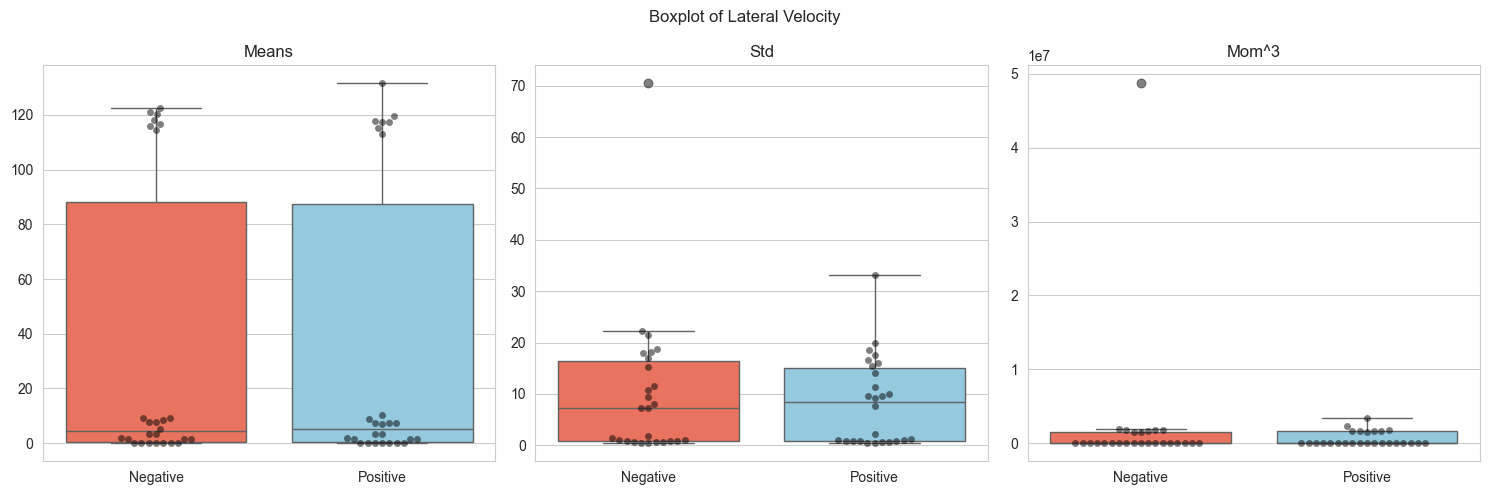

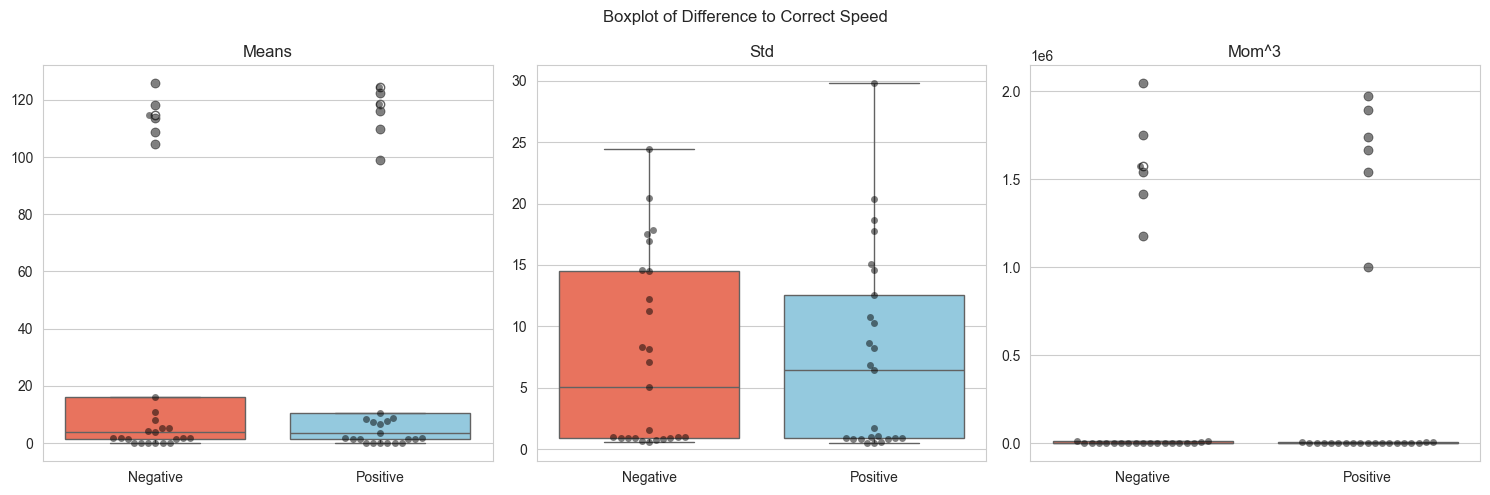

c:\Users\JonathanKubik\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\JonathanKubik\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 24.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


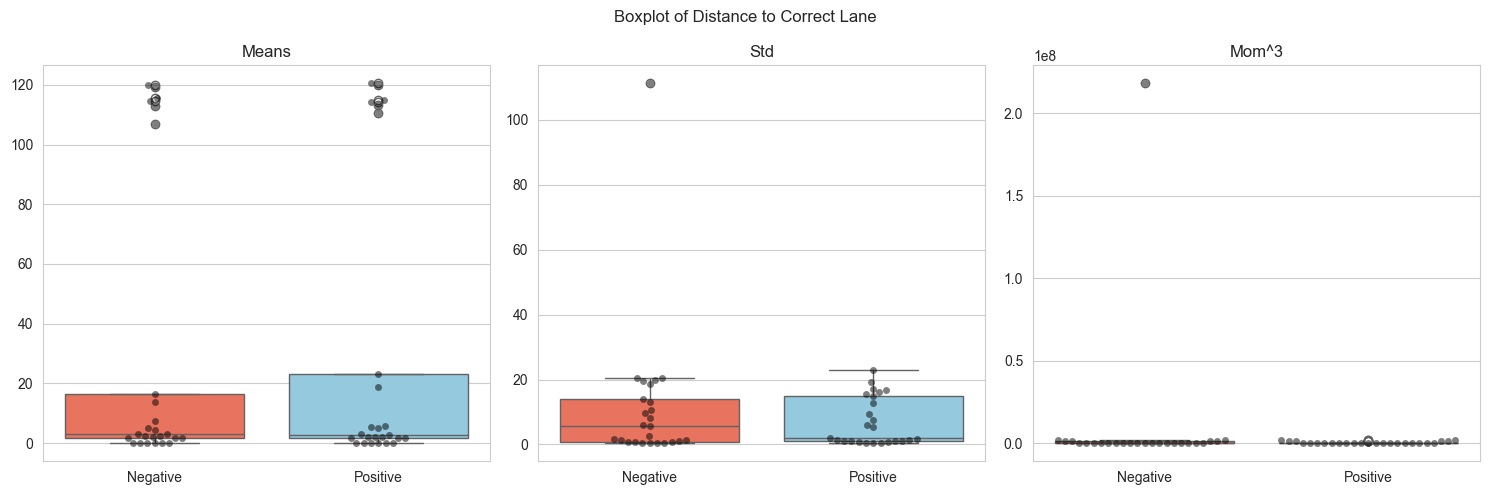

In [ ]:
plot_all_boxplot_perf(datasets=datasets, titles=titles)

In [ ]:
intense_stats_wo, calm_stats_wo = get_all_stats(remove_outliers=['VelocityX', 'DistanceToTargetPosition', 'DistanceToTargetSpeed'])
dataset_wo = generate_datasets(calm_stats=calm_stats_wo, intense_stats=intense_stats_wo, pairs=pairs)

['C1K4L9S8', 'D0P7X9W6', 'G2Y7J4Q1', 'G9K4W1Z0', 'I8L4N6G7', 'J4X1T0D2', 'J6W7Q4H5', 'K4G7Y9O2', 'L0S1Z2I3', 'L1N3B5O2', 'M0R6U5F9', 'M4H6R2W9', 'M7D3F5K4', 'N7P5B8G0', 'O4A0U8R1', 'R0V9G1L4', 'U6O5V2T9', 'V9L0P2K7', 'X5Q0G4J2', 'Z6A2W1E8']
C1K4L9S8 OK
D0P7X9W6 OK
G2Y7J4Q1 OK
G9K4W1Z0 OK
I8L4N6G7 OK
J4X1T0D2 OK
J6W7Q4H5 OK
K4G7Y9O2 OK
L0S1Z2I3 OK
L1N3B5O2 OK


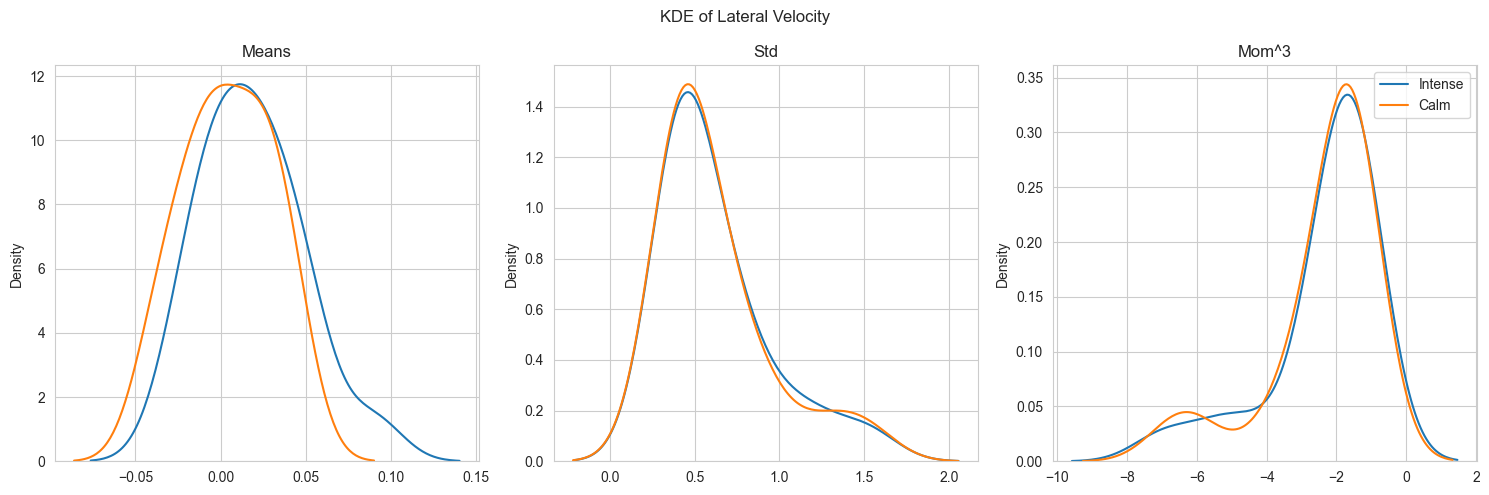

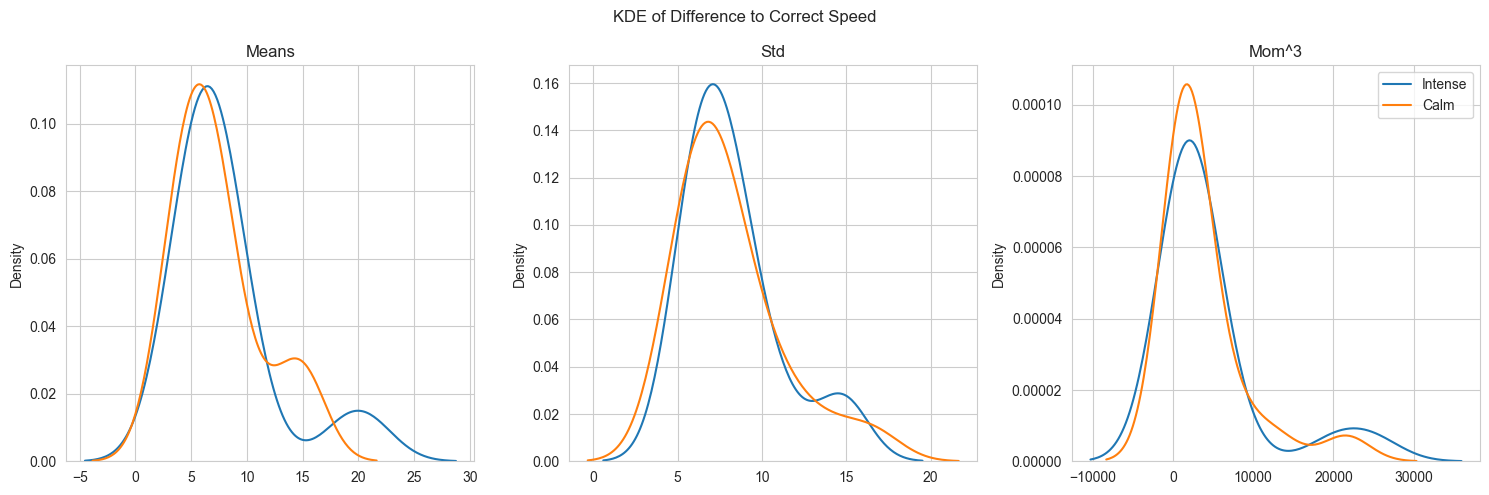

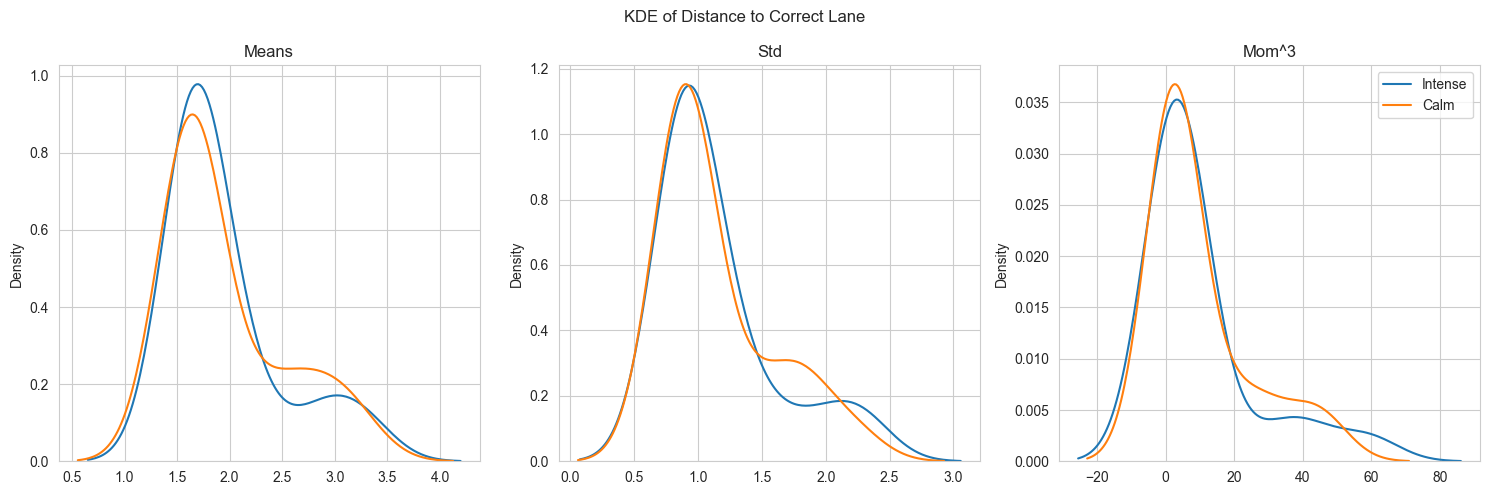

In [ ]:
plot_all_perf_param_kdes(datasets=dataset_wo, titles=titles)

In [ ]:

for j, (intense, calm) in enumerate(dataset_wo):
    print(f'\nT-test results for {titles[j]}, intense vs calm:')
    print(f'Means: {ttest_rel([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {ttest_rel([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {ttest_rel([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')


T-test results for Lateral Velocity, intense vs calm:
Means: 0.07833641281265952
STDs: 0.6881220882944239
Mom^3s: 0.6630357232082915

T-test results for Difference to Correct Speed, intense vs calm:
Means: 0.37864575481573126
STDs: 0.7778721469406782
Mom^3s: 0.5540106785053285

T-test results for Distance to Correct Lane, intense vs calm:
Means: 0.8192949464483934
STDs: 0.9363408634181676
Mom^3s: 0.9930440847089991


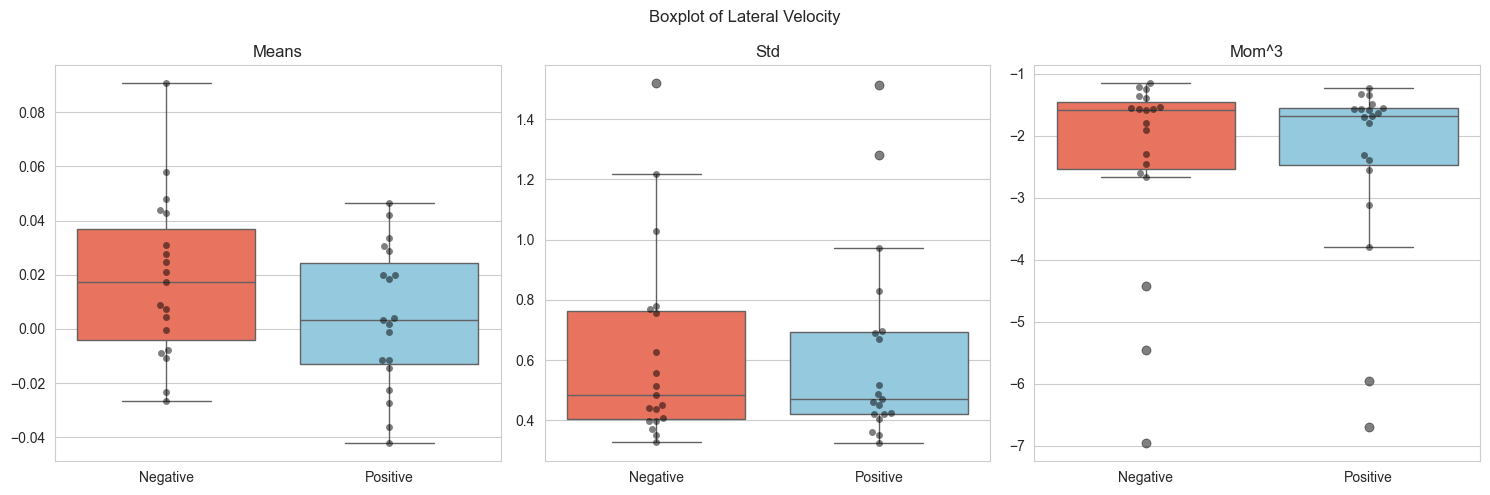

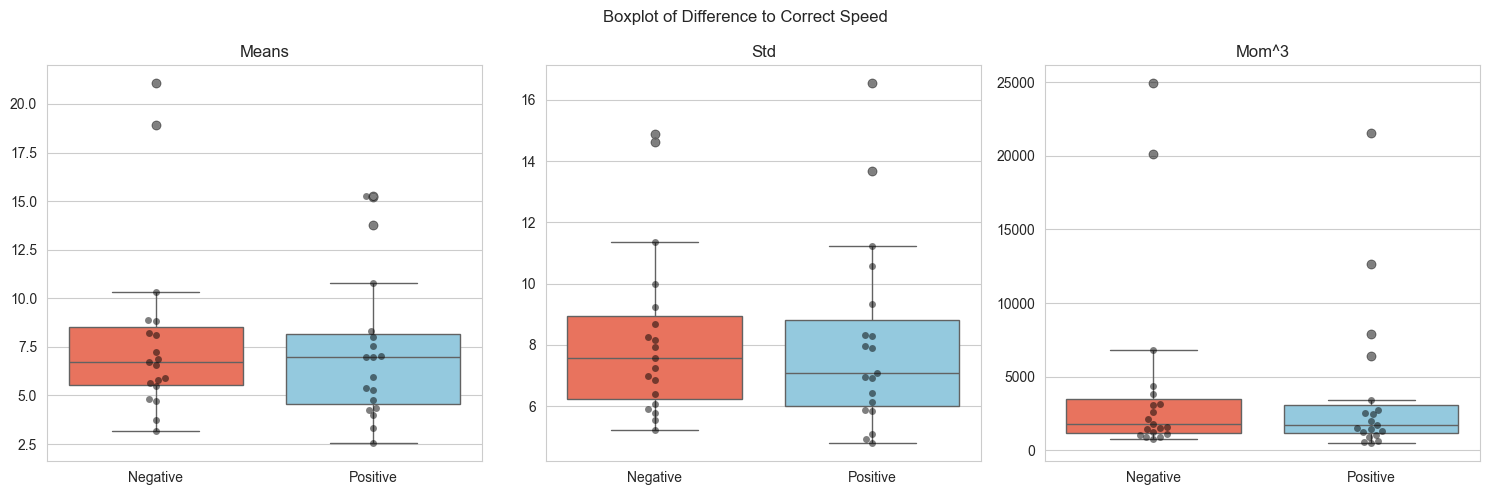

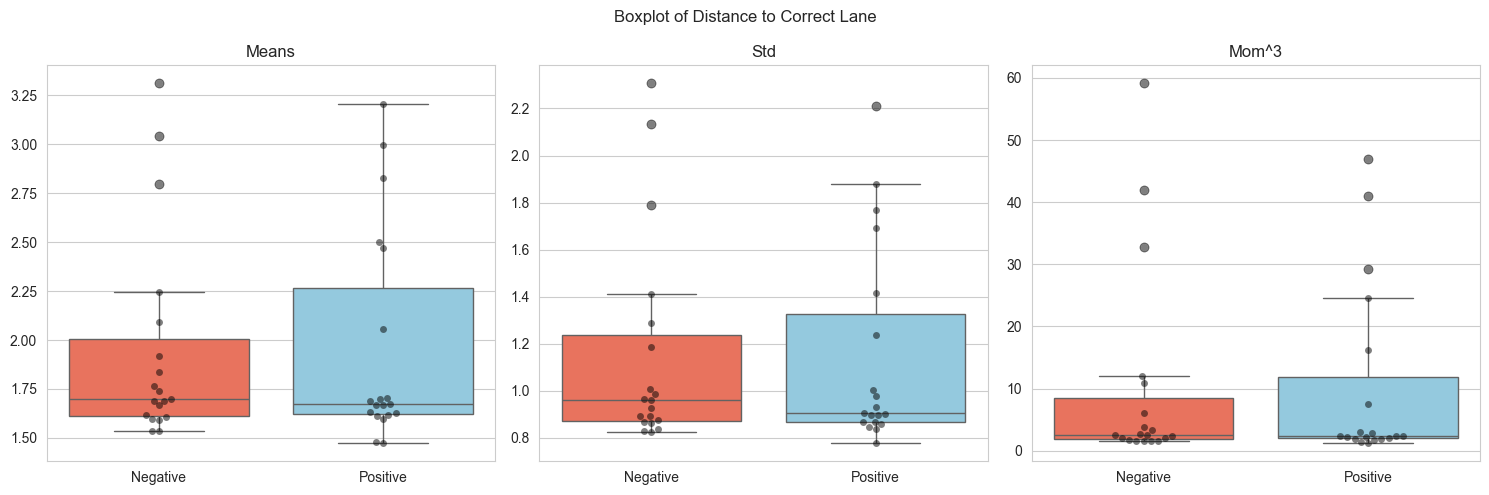

In [ ]:
plot_all_boxplot_perf(datasets=dataset_wo, titles=titles)

In [ ]:
speed_intense = datasets[1][0]
speed_calm = datasets[1][1]

### Analyze Gender Dependencies

##### Male only

['C1K4L9S8', 'D0P7X9W6', 'G2Y7J4Q1', 'G9K4W1Z0', 'I8L4N6G7', 'J4X1T0D2', 'J6W7Q4H5', 'K4G7Y9O2', 'L0S1Z2I3', 'L1N3B5O2', 'M0R6U5F9', 'M4H6R2W9', 'M7D3F5K4', 'N7P5B8G0', 'O4A0U8R1', 'R0V9G1L4', 'U6O5V2T9', 'V9L0P2K7', 'X5Q0G4J2', 'Z6A2W1E8']
C1K4L9S8 OK
D0P7X9W6 OK
G2Y7J4Q1 OK
Skipping G2Y7J4Q1 cause of gender
G9K4W1Z0 OK
I8L4N6G7 OK
Skipping I8L4N6G7 cause of gender
J4X1T0D2 OK
Skipping J4X1T0D2 cause of gender
J6W7Q4H5 OK
Skipping J6W7Q4H5 cause of gender
K4G7Y9O2 OK
L0S1Z2I3 OK
Skipping L0S1Z2I3 cause of gender
L1N3B5O2 OK
Skipping L1N3B5O2 cause of gender
M0R6U5F9 OK
Skipping M0R6U5F9 cause of gender
M4H6R2W9 OK
M7D3F5K4 OK
N7P5B8G0 OK
O4A0U8R1 OK
R0V9G1L4 FAIL
U6O5V2T9 OK
V9L0P2K7 OK
X5Q0G4J2 OK
Z6A2W1E8 OK


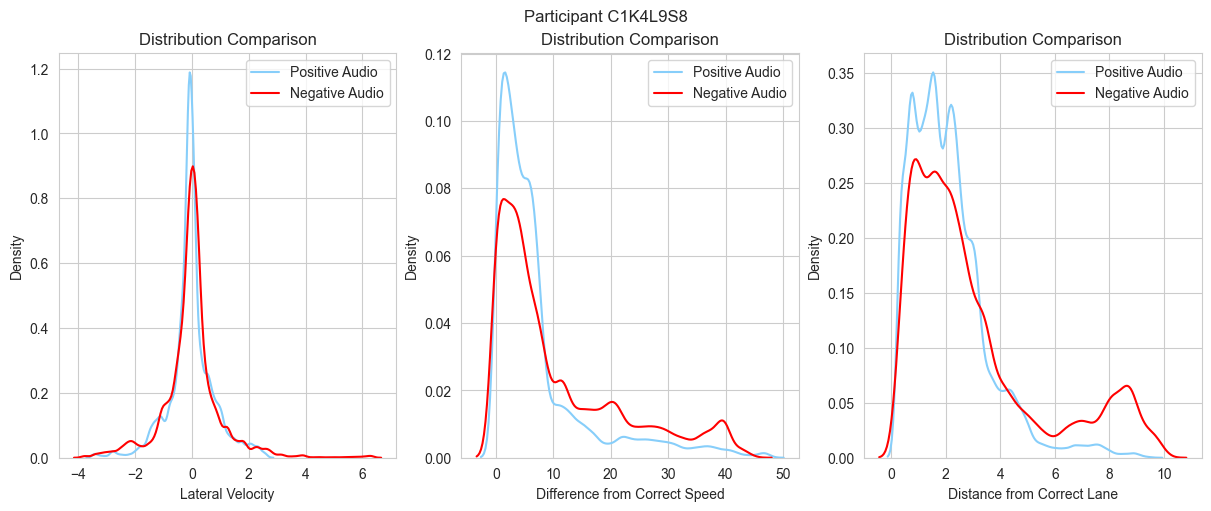

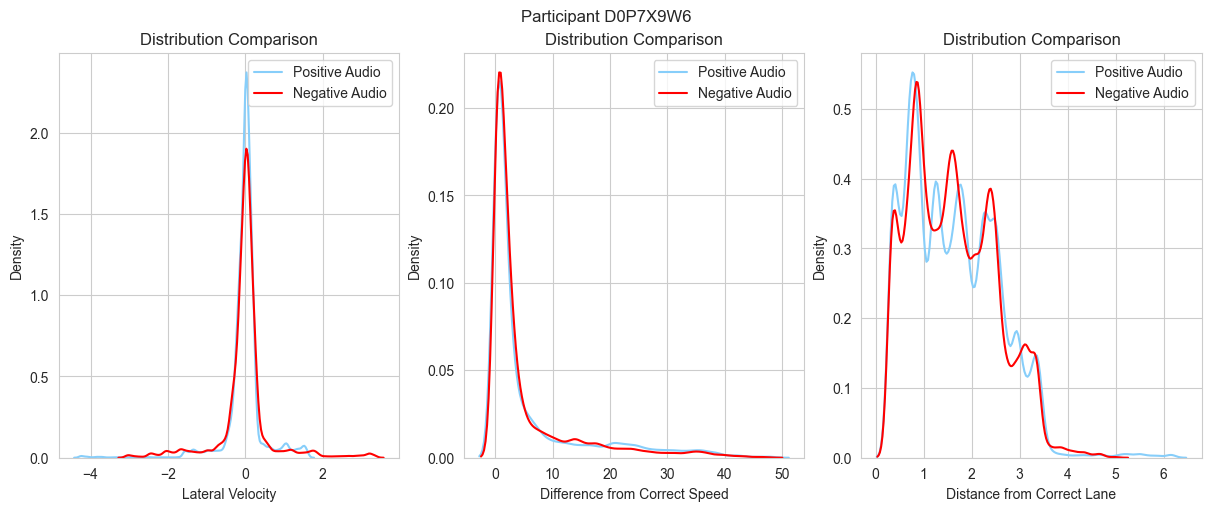

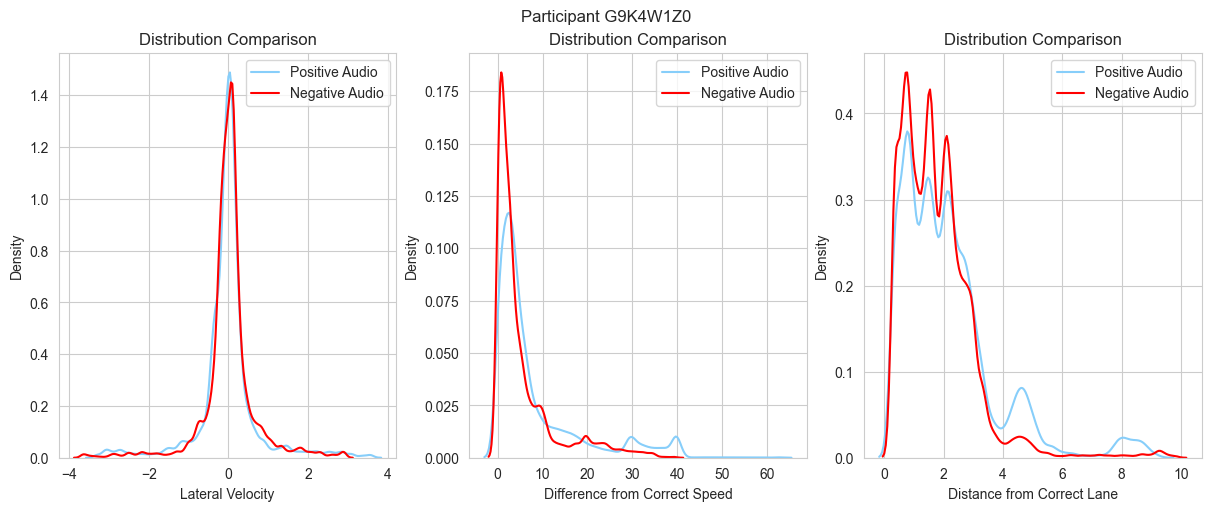

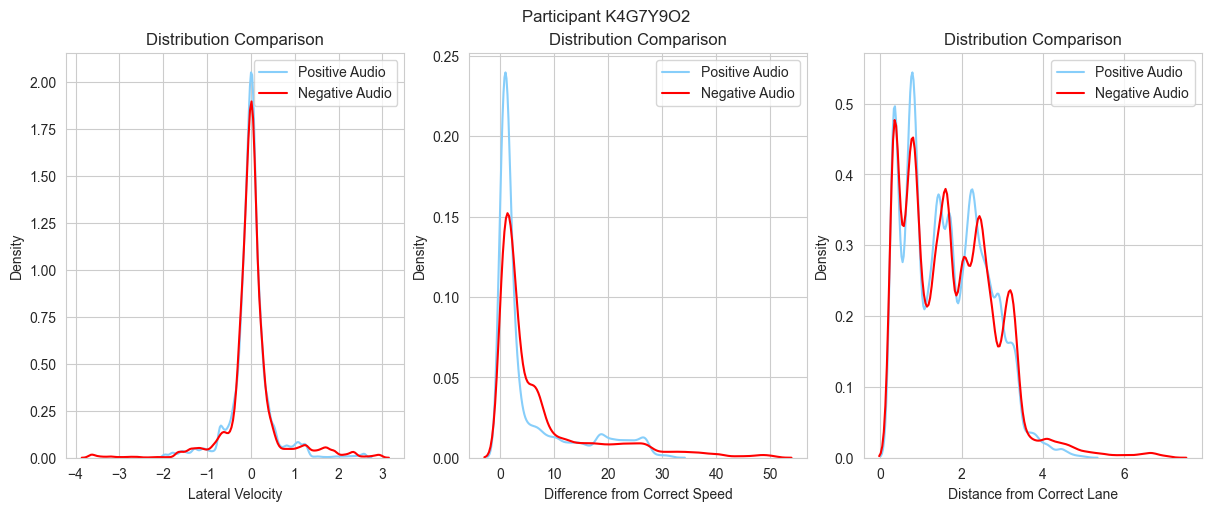

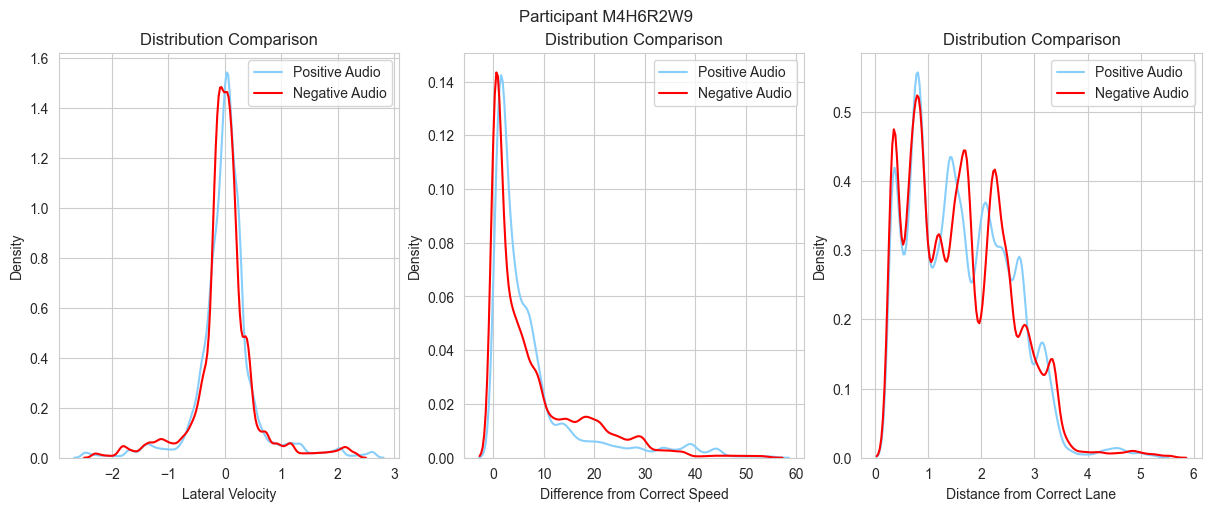

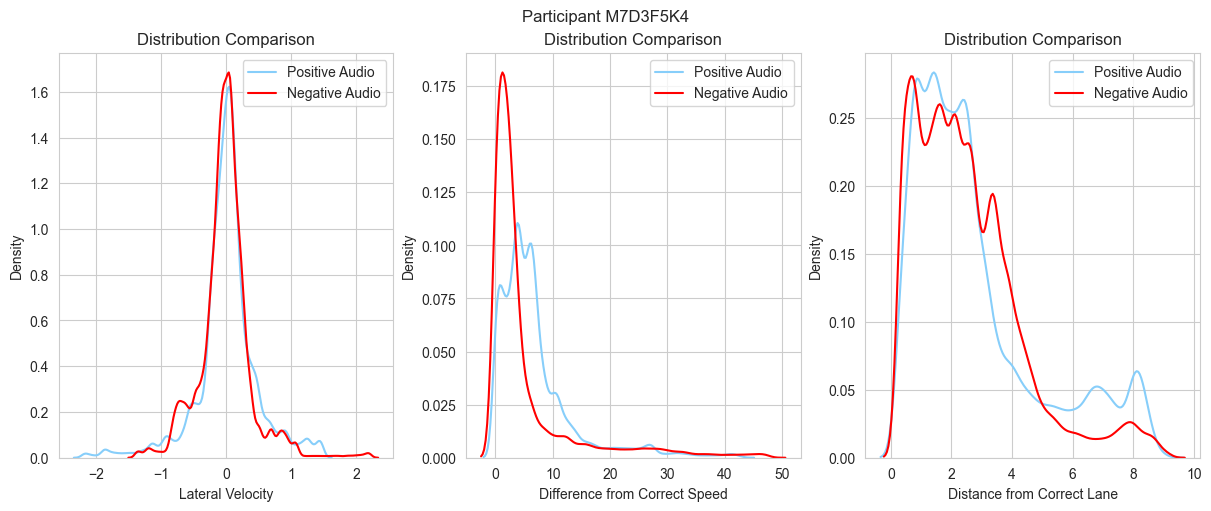

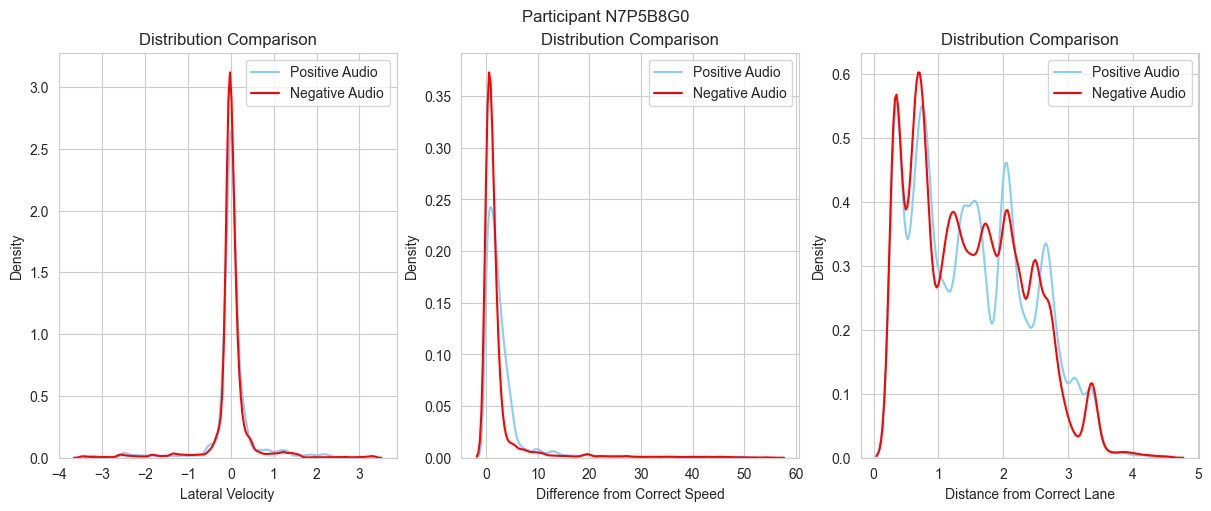

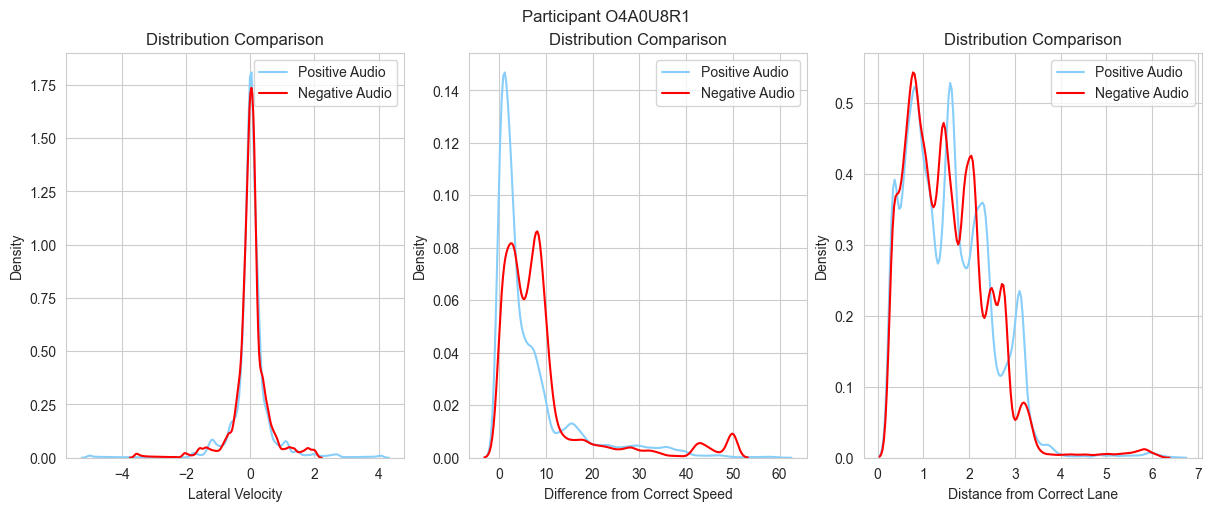

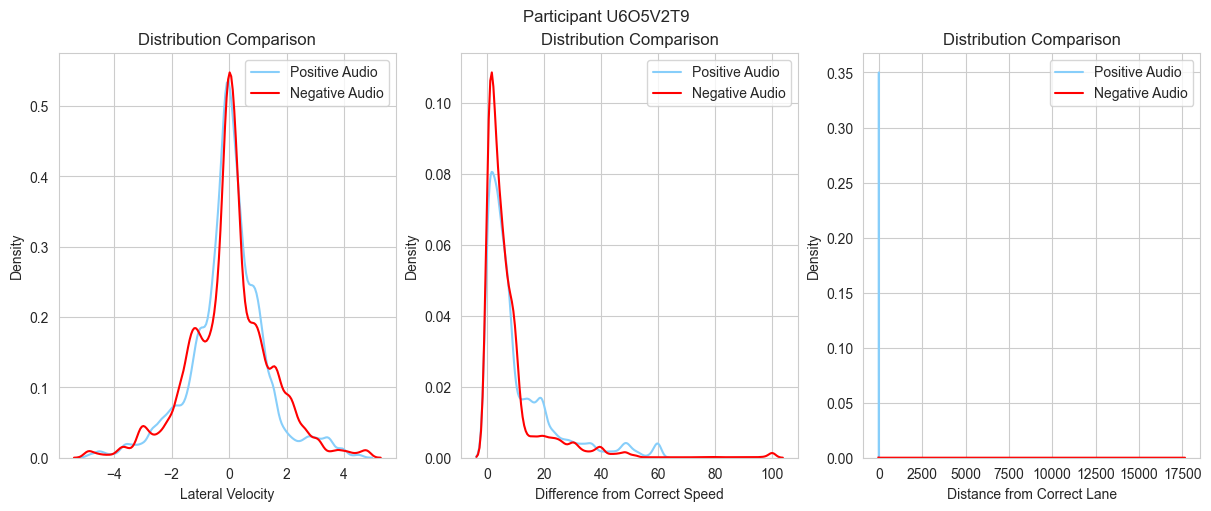

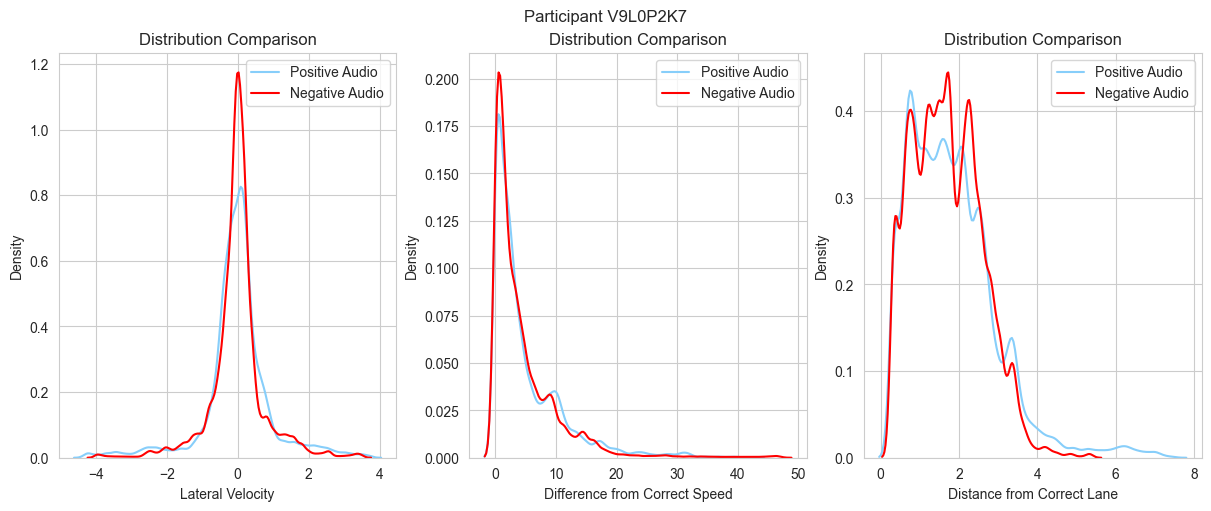

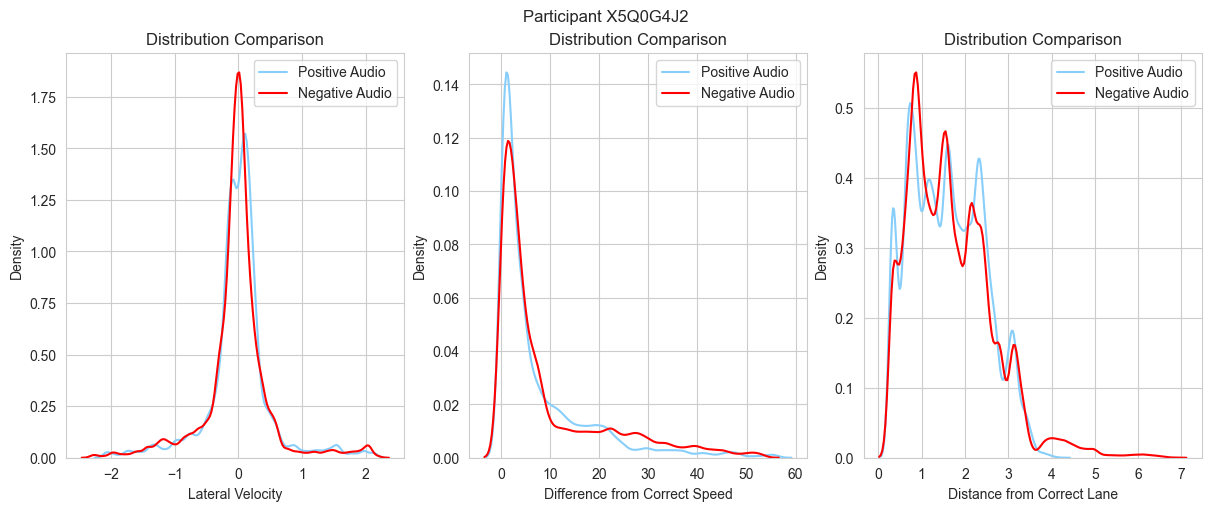

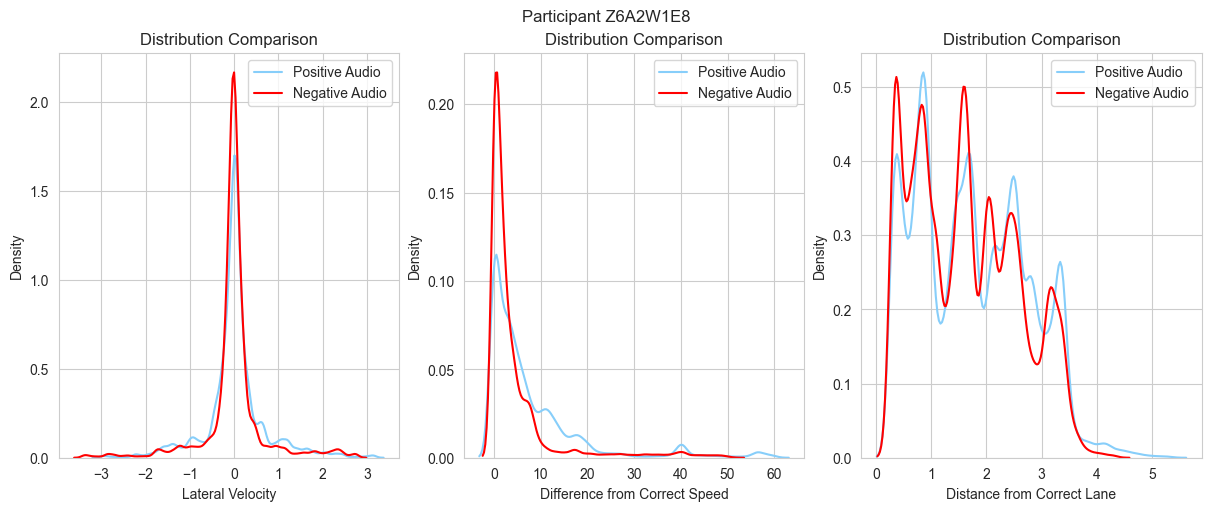

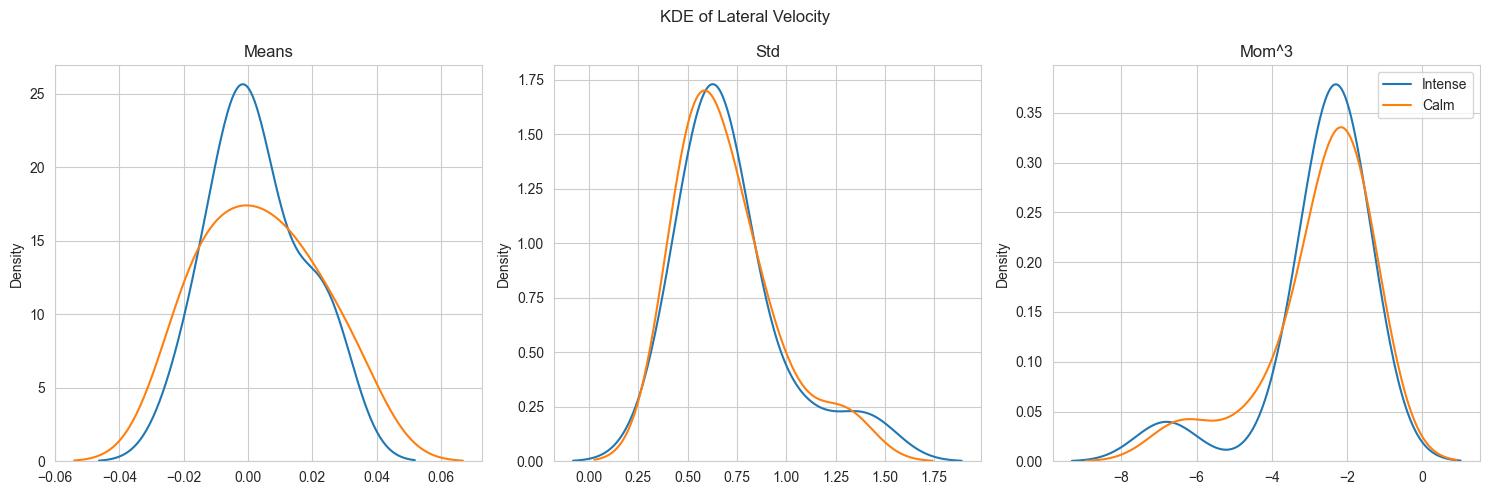

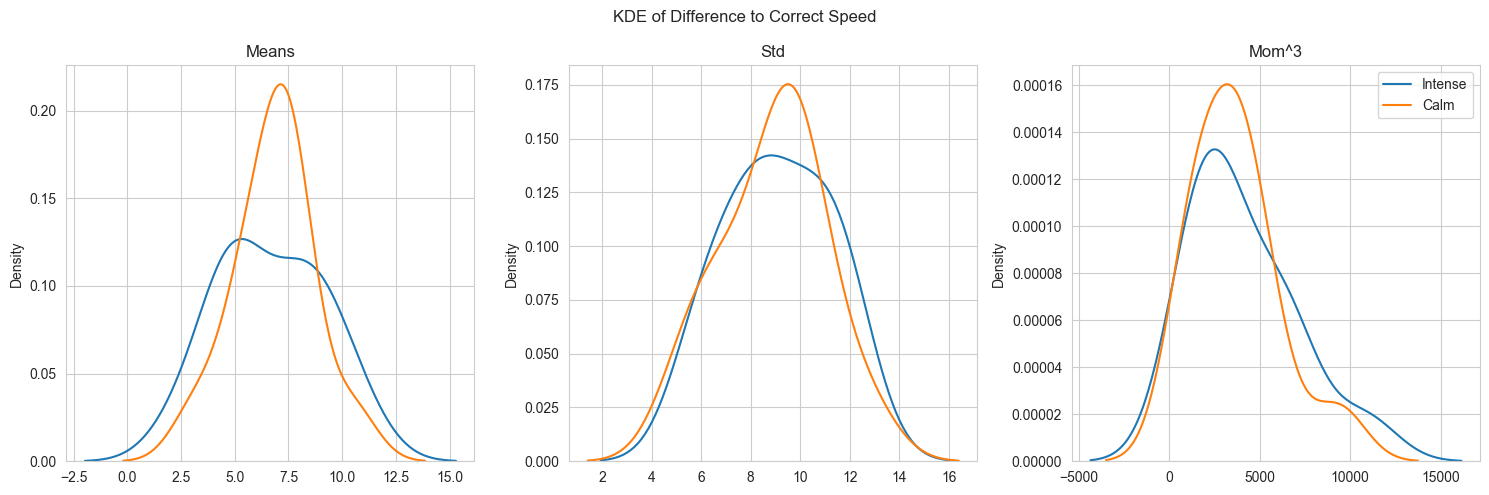

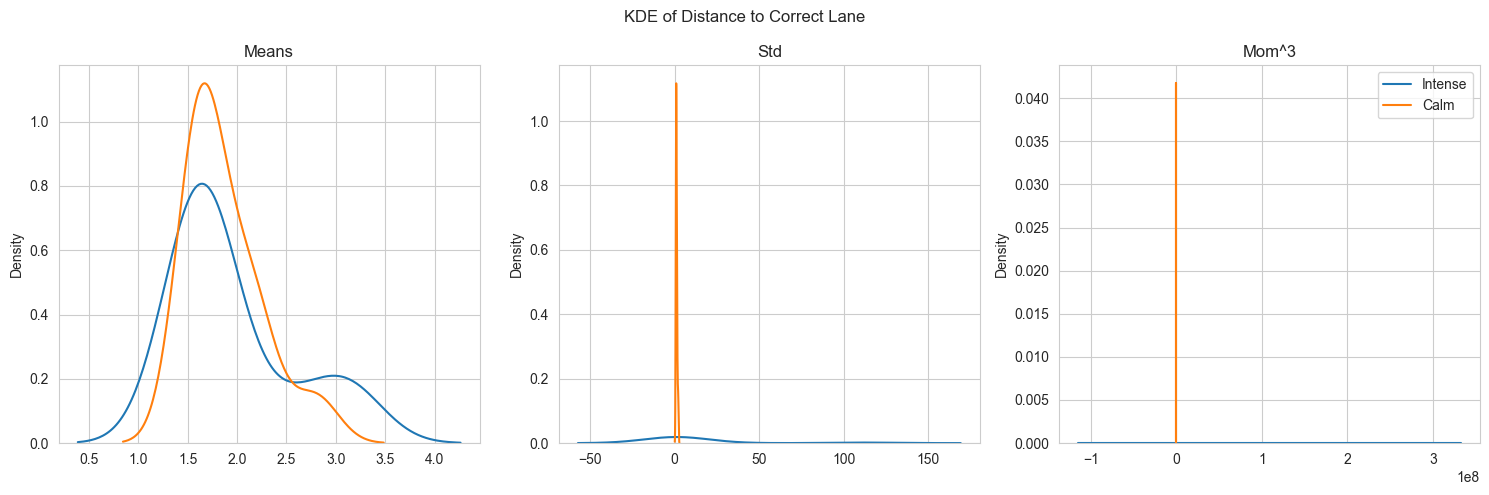

In [ ]:
calm_man, intense_man = get_all_stats(drop_gender='FEMALE')
dataset_man = generate_datasets(calm_stats=calm_man, intense_stats=intense_man, pairs=pairs)
plot_all_perf_param_kdes(datasets=dataset_man, titles=titles)

In [ ]:
for j, (intense, calm) in enumerate(dataset_man):
    print(f'\nT-test results for {titles[j]}, intense vs calm:')
    print(f'Means: {ttest_rel([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {ttest_rel([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {ttest_rel([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')


T-test results for Lateral Velocity, intense vs calm:
Means: 0.8966255274417589
STDs: 0.6411000442012771
Mom^3s: 0.8041302498488301

T-test results for Difference to Correct Speed, intense vs calm:
Means: 0.7951762513457201
STDs: 0.6789505631484392
Mom^3s: 0.4812158055826974

T-test results for Distance to Correct Lane, intense vs calm:
Means: 0.5237563333502224
STDs: 0.33810260571861295
Mom^3s: 0.33880064390495923


##### With outliers removed

['C1K4L9S8', 'D0P7X9W6', 'G2Y7J4Q1', 'G9K4W1Z0', 'I8L4N6G7', 'J4X1T0D2', 'J6W7Q4H5', 'K4G7Y9O2', 'L0S1Z2I3', 'L1N3B5O2', 'M0R6U5F9', 'M4H6R2W9', 'M7D3F5K4', 'N7P5B8G0', 'O4A0U8R1', 'R0V9G1L4', 'U6O5V2T9', 'V9L0P2K7', 'X5Q0G4J2', 'Z6A2W1E8']
C1K4L9S8 OK
D0P7X9W6 OK
G2Y7J4Q1 OK
Skipping G2Y7J4Q1 cause of gender
G9K4W1Z0 OK
I8L4N6G7 OK
Skipping I8L4N6G7 cause of gender
J4X1T0D2 OK
Skipping J4X1T0D2 cause of gender
J6W7Q4H5 OK
Skipping J6W7Q4H5 cause of gender
K4G7Y9O2 OK
L0S1Z2I3 OK
Skipping L0S1Z2I3 cause of gender
L1N3B5O2 OK
Skipping L1N3B5O2 cause of gender
M0R6U5F9 OK
Skipping M0R6U5F9 cause of gender
M4H6R2W9 OK
M7D3F5K4 OK
N7P5B8G0 OK
O4A0U8R1 OK
R0V9G1L4 FAIL
U6O5V2T9 OK
V9L0P2K7 OK
X5Q0G4J2 OK
Z6A2W1E8 OK


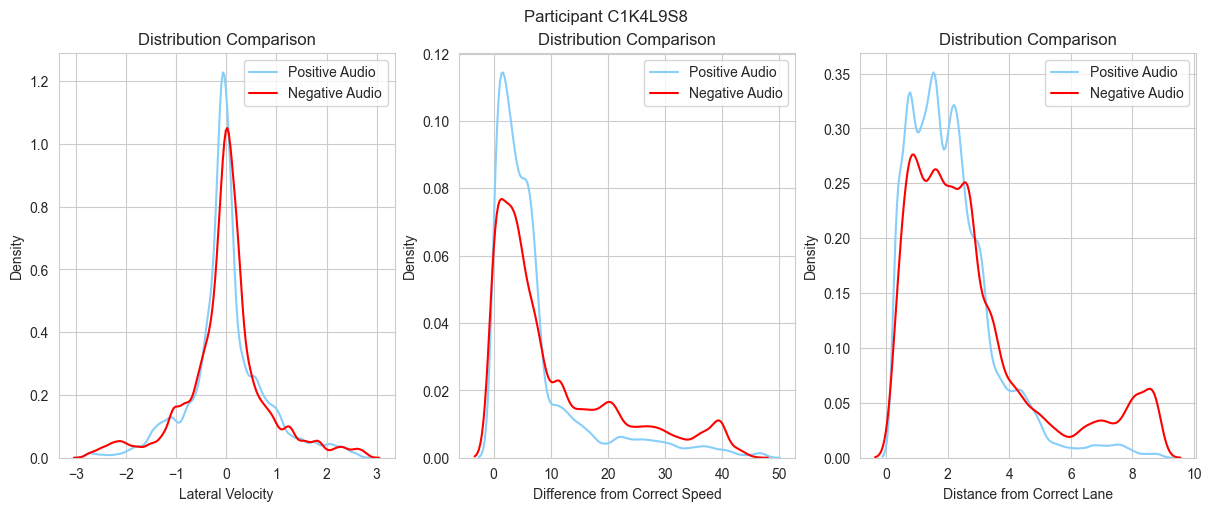

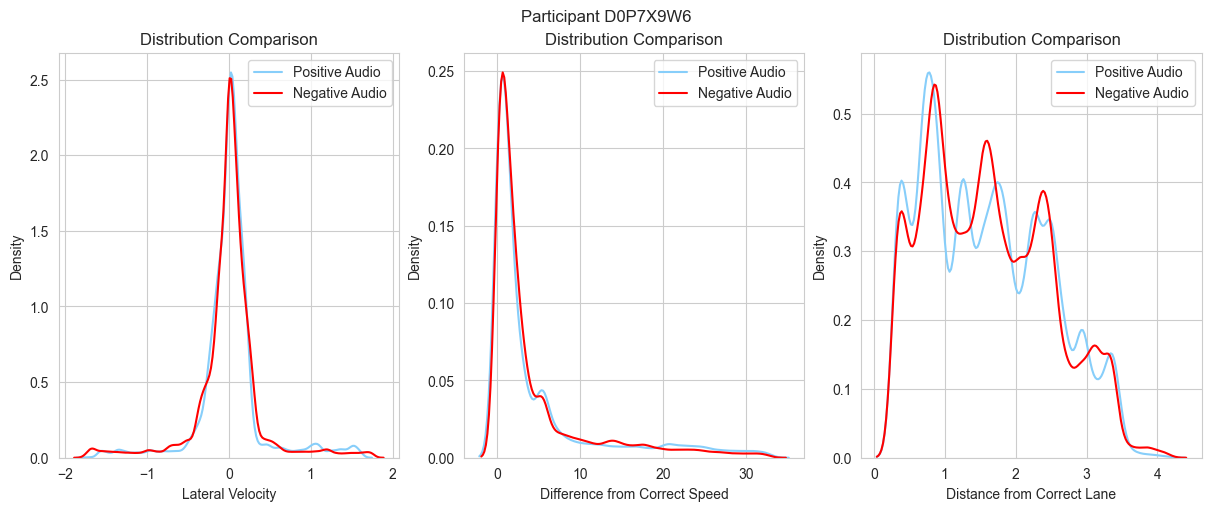

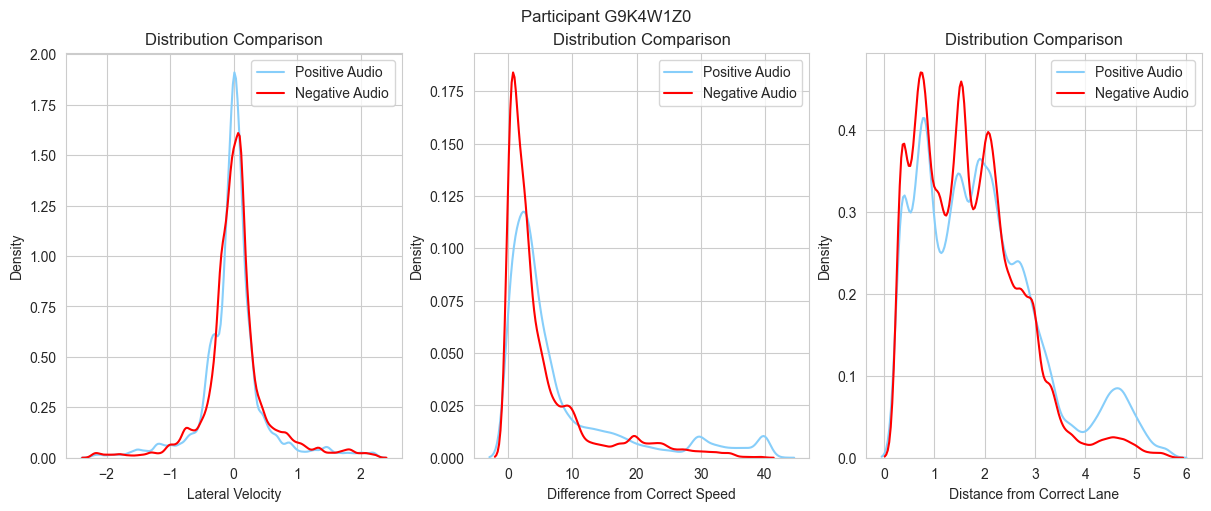

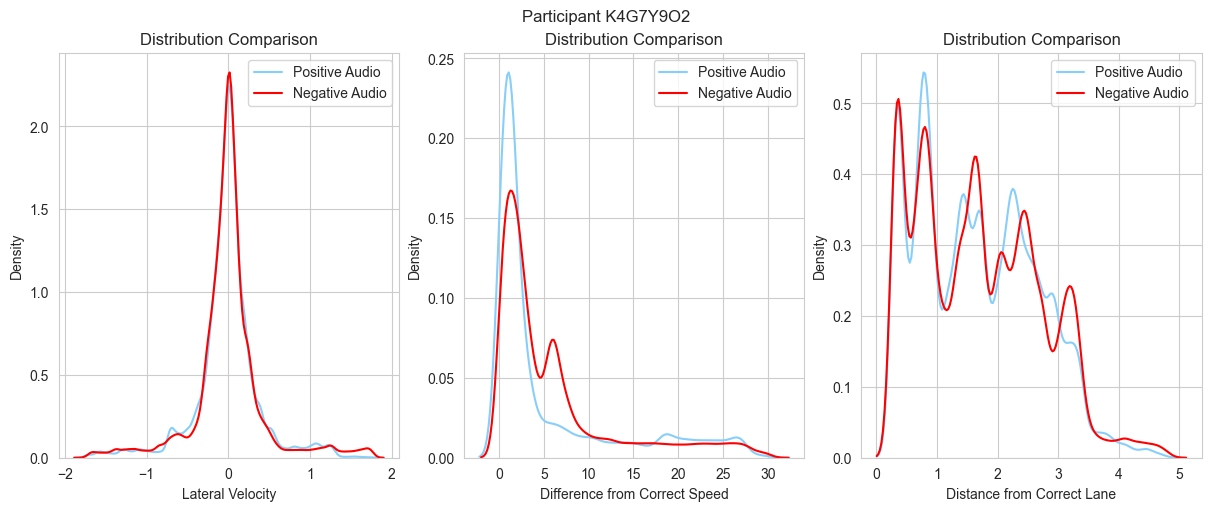

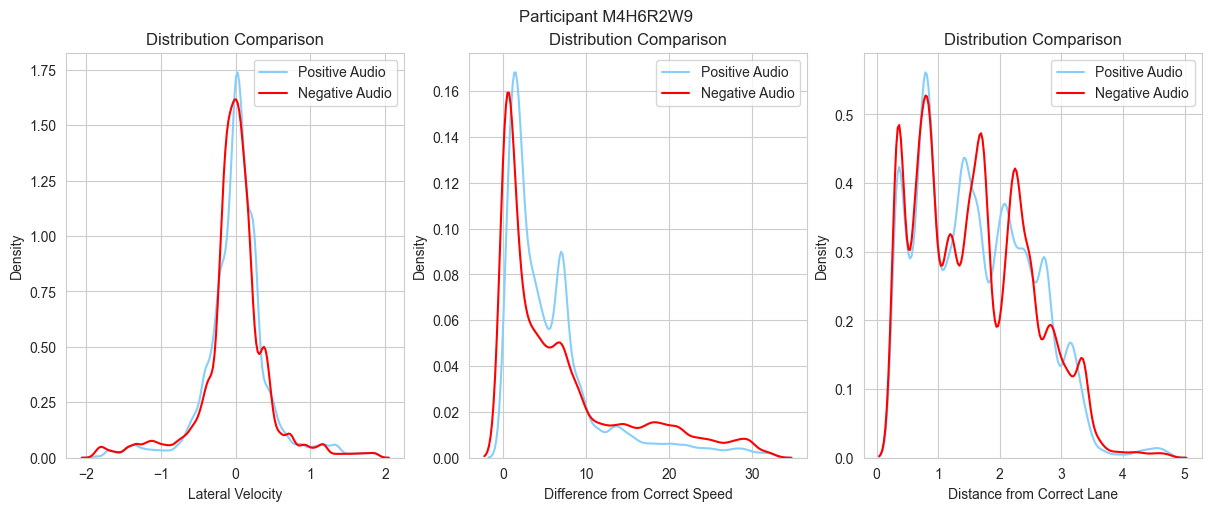

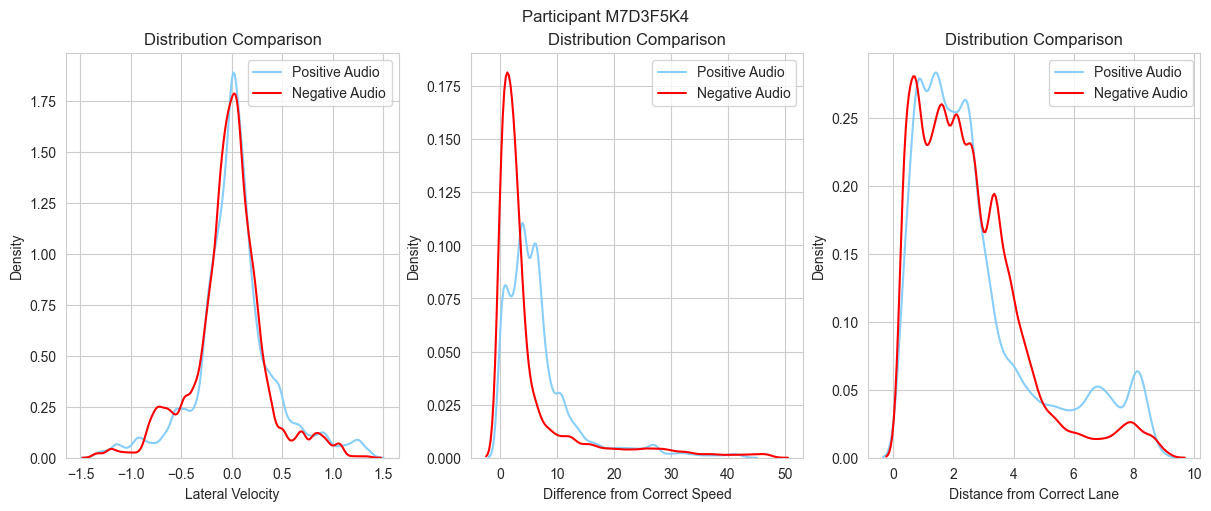

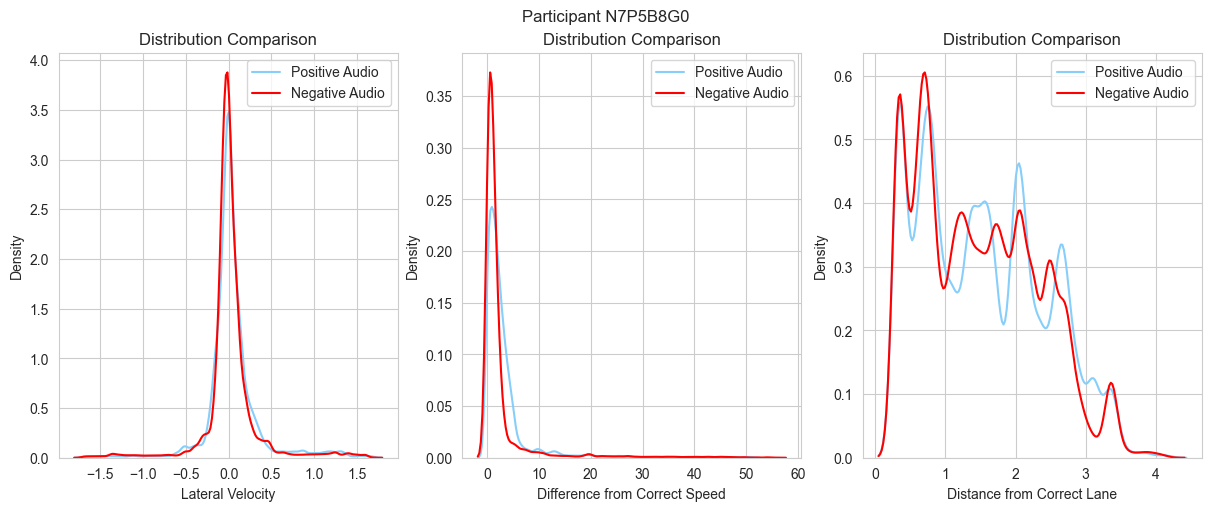

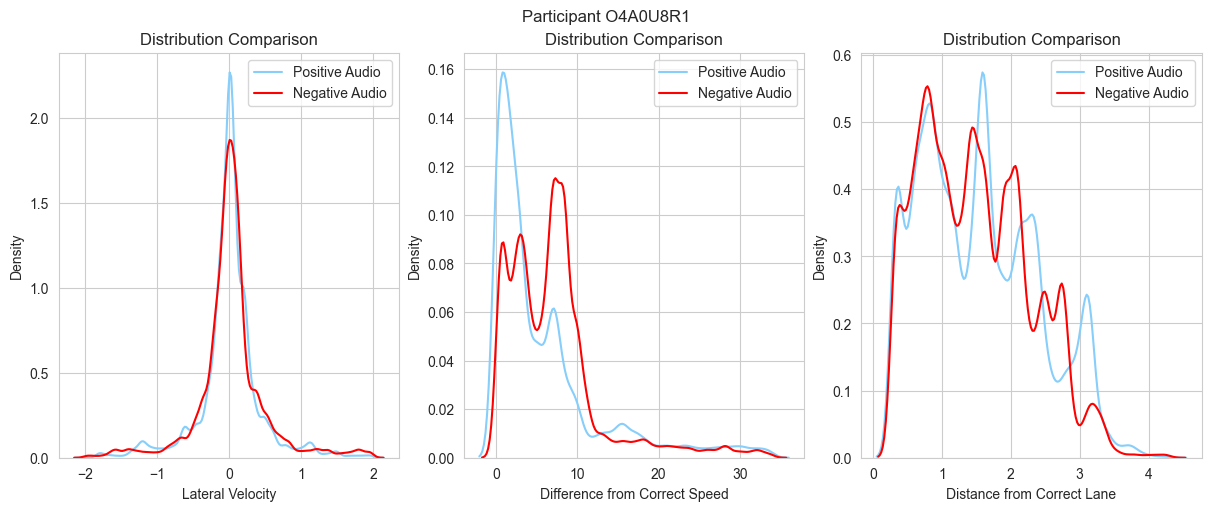

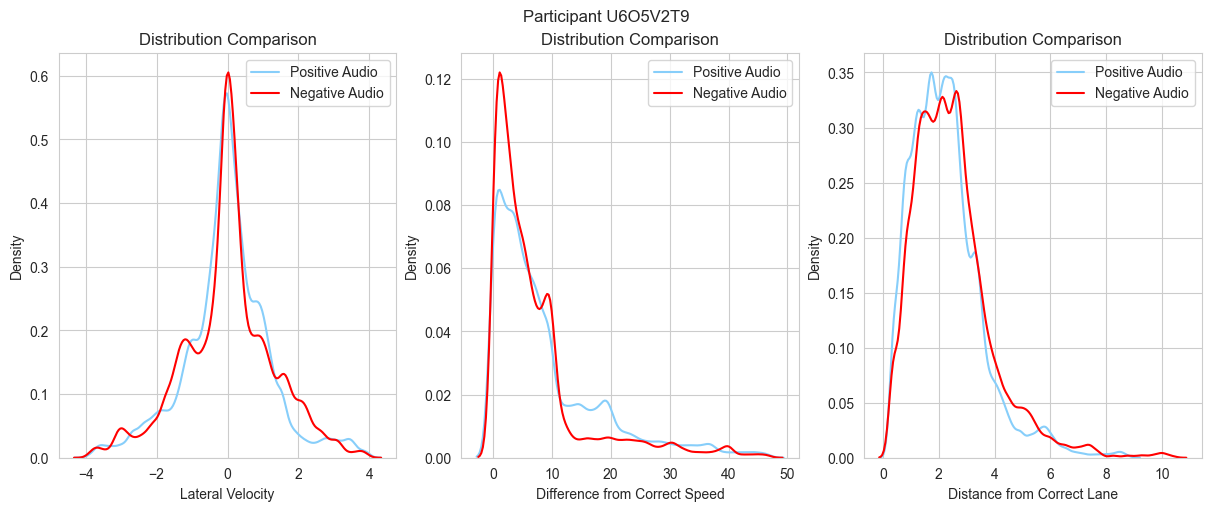

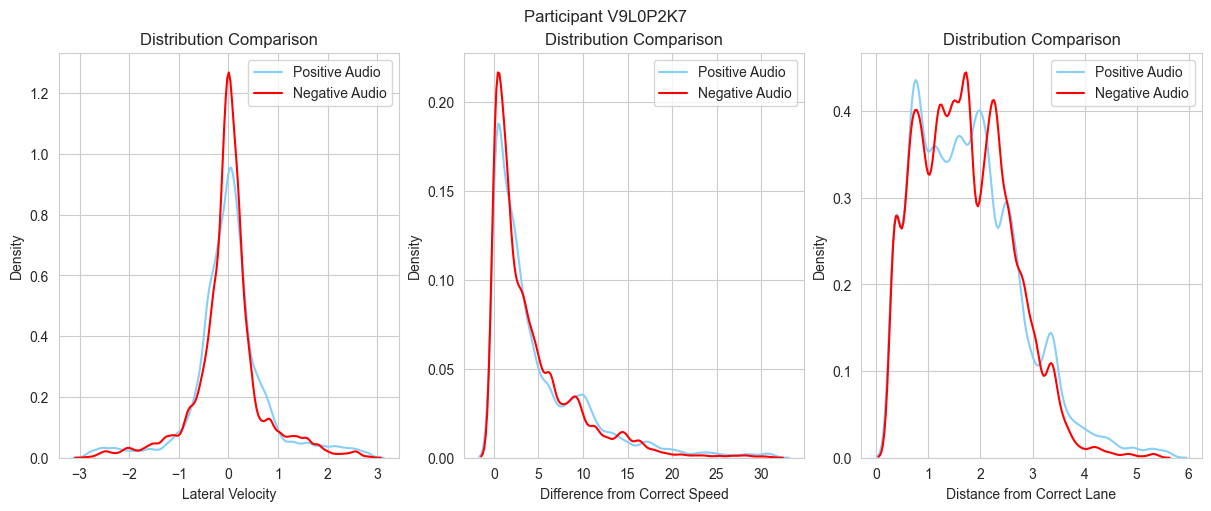

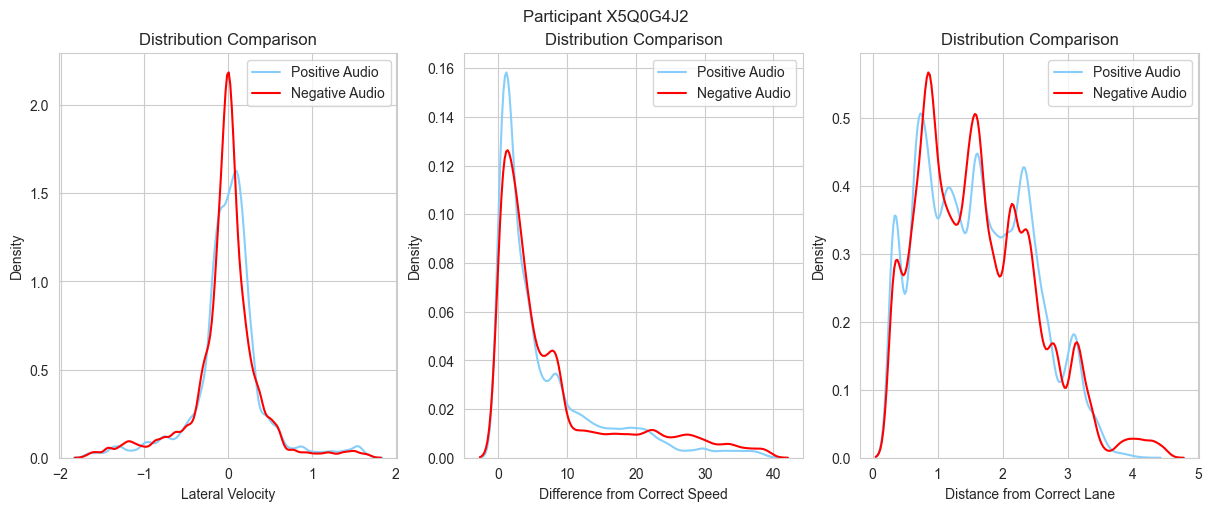

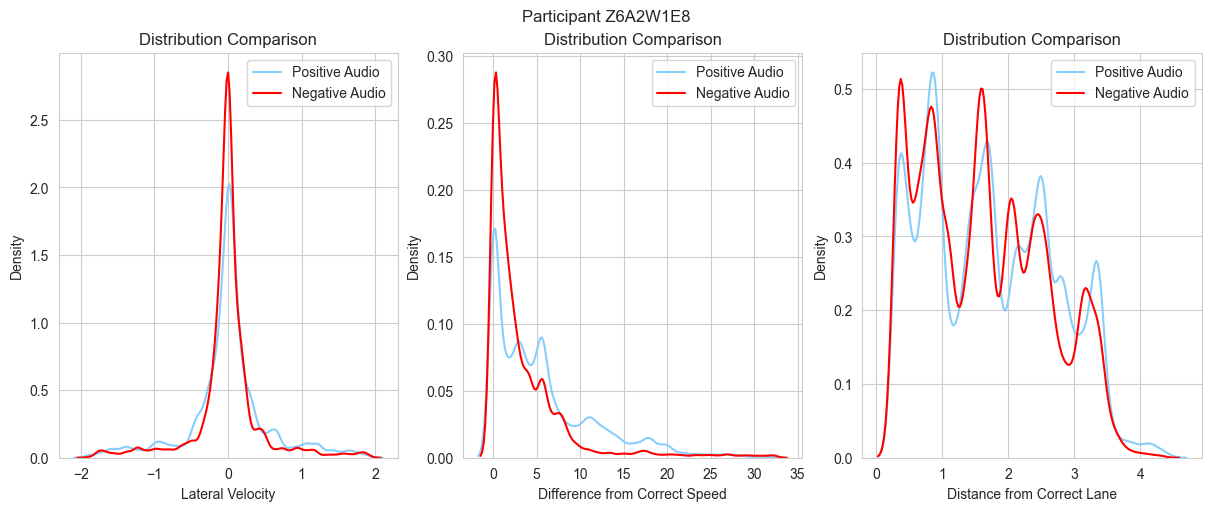

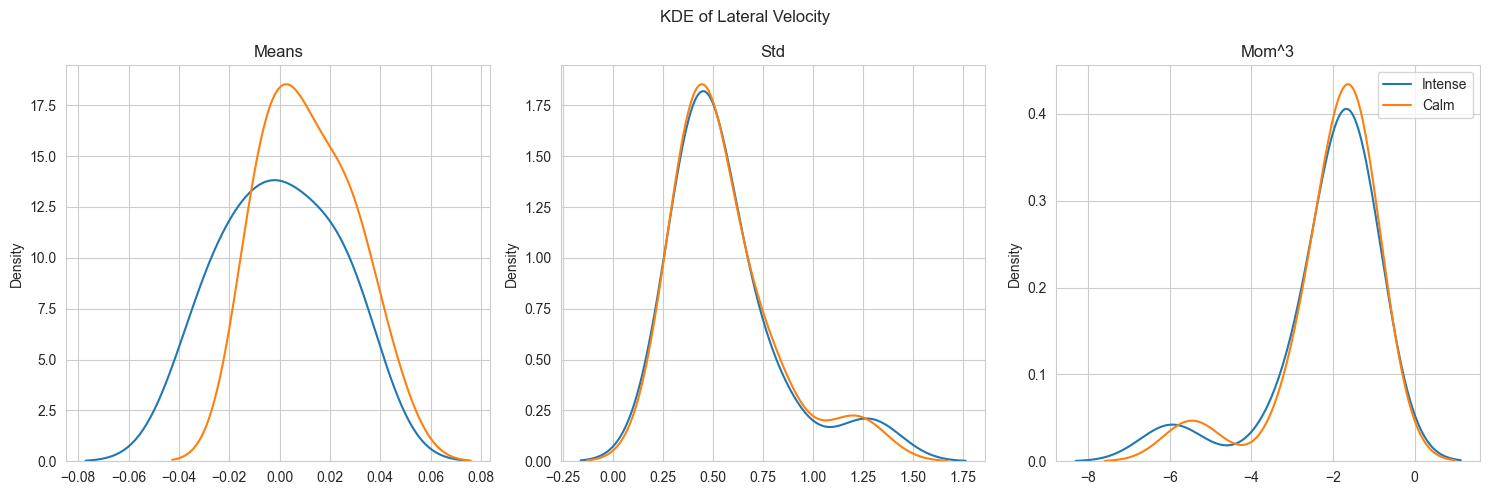

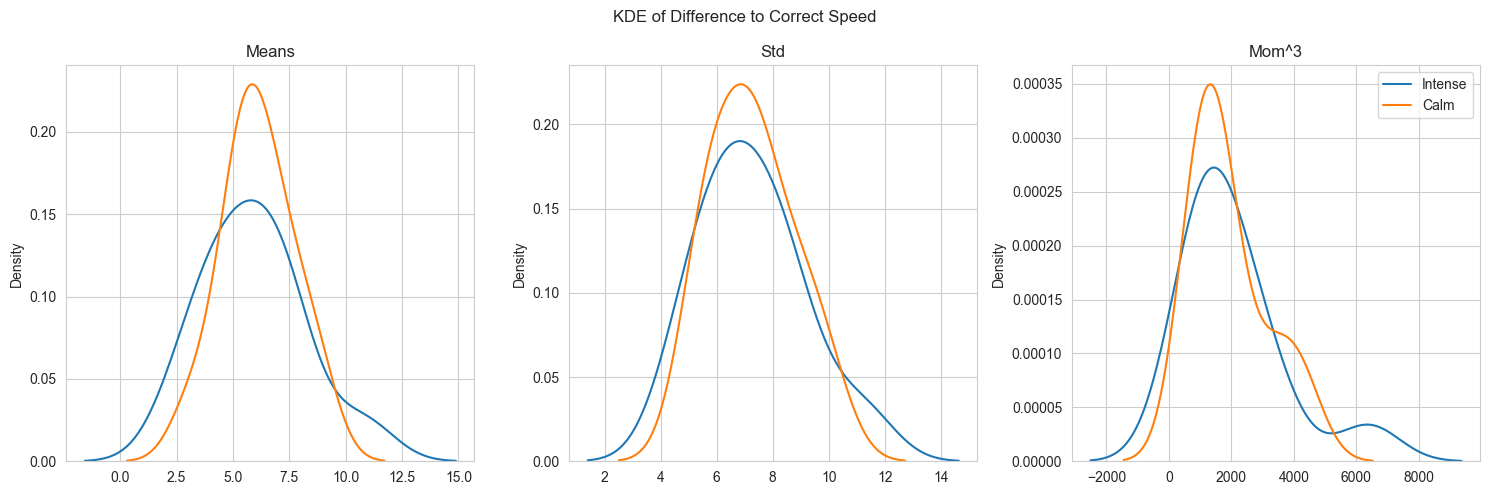

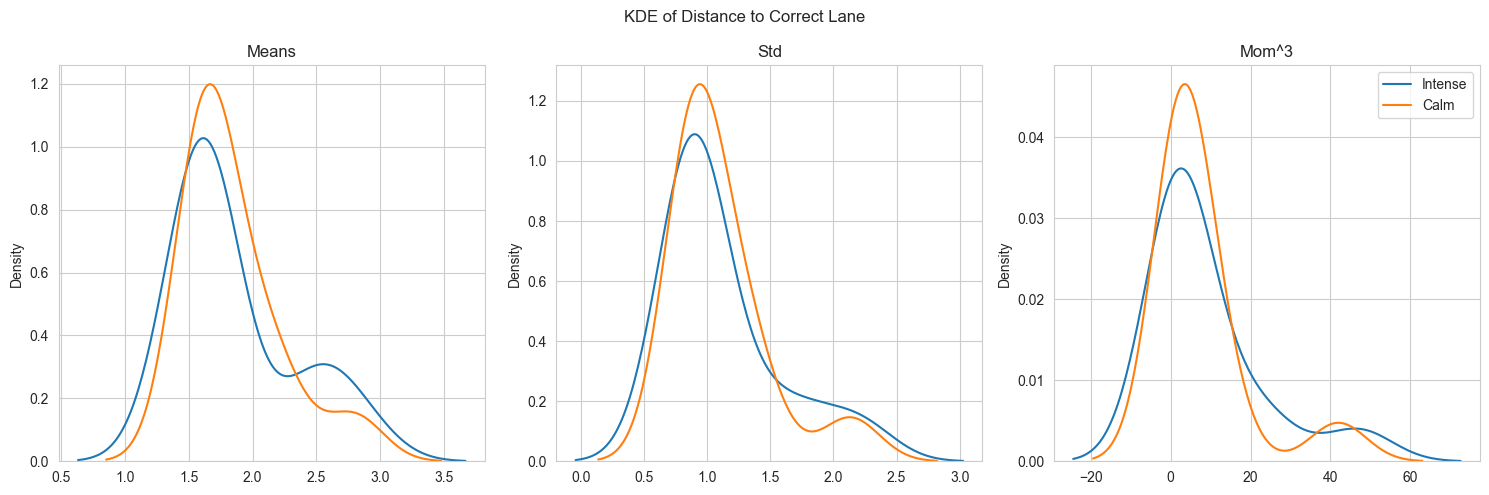

In [ ]:
calm_man_outl, intense_man_outl = get_all_stats(drop_gender='FEMALE',remove_outliers=['VelocityX', 'DistanceToTargetPosition', 'DistanceToTargetSpeed'])
dataset_man_outl = generate_datasets(calm_stats=calm_man_outl, intense_stats=intense_man_outl, pairs=pairs)
plot_all_perf_param_kdes(datasets=dataset_man_outl, titles=titles)

In [ ]:
for j, (intense, calm) in enumerate(dataset_man_outl):
    print(f'\nT-test results for {titles[j]}, intense vs calm:')
    print(f'Means: {ttest_rel([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {ttest_rel([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {ttest_rel([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')


T-test results for Lateral Velocity, intense vs calm:
Means: 0.21455779259860913
STDs: 0.9025188083563968
Mom^3s: 0.21621606147147773

T-test results for Difference to Correct Speed, intense vs calm:
Means: 0.6942613370824889
STDs: 0.9928126694093327
Mom^3s: 0.7883550968788549

T-test results for Distance to Correct Lane, intense vs calm:
Means: 0.8597781195951577
STDs: 0.8554482696474912
Mom^3s: 0.6685909656924475


##### Female only

['C1K4L9S8', 'D0P7X9W6', 'G2Y7J4Q1', 'G9K4W1Z0', 'I8L4N6G7', 'J4X1T0D2', 'J6W7Q4H5', 'K4G7Y9O2', 'L0S1Z2I3', 'L1N3B5O2', 'M0R6U5F9', 'M4H6R2W9', 'M7D3F5K4', 'N7P5B8G0', 'O4A0U8R1', 'R0V9G1L4', 'U6O5V2T9', 'V9L0P2K7', 'X5Q0G4J2', 'Z6A2W1E8']
C1K4L9S8 OK
Skipping C1K4L9S8 cause of gender
D0P7X9W6 OK
Skipping D0P7X9W6 cause of gender
G2Y7J4Q1 OK
G9K4W1Z0 OK
Skipping G9K4W1Z0 cause of gender
I8L4N6G7 OK
J4X1T0D2 OK
J6W7Q4H5 OK
K4G7Y9O2 OK
Skipping K4G7Y9O2 cause of gender
L0S1Z2I3 OK
L1N3B5O2 OK
M0R6U5F9 OK
M4H6R2W9 OK
Skipping M4H6R2W9 cause of gender
M7D3F5K4 OK
Skipping M7D3F5K4 cause of gender
N7P5B8G0 OK
Skipping N7P5B8G0 cause of gender
O4A0U8R1 OK
Skipping O4A0U8R1 cause of gender
R0V9G1L4 FAIL
U6O5V2T9 OK
Skipping U6O5V2T9 cause of gender
V9L0P2K7 OK
Skipping V9L0P2K7 cause of gender
X5Q0G4J2 OK
Skipping X5Q0G4J2 cause of gender
Z6A2W1E8 OK
Skipping Z6A2W1E8 cause of gender


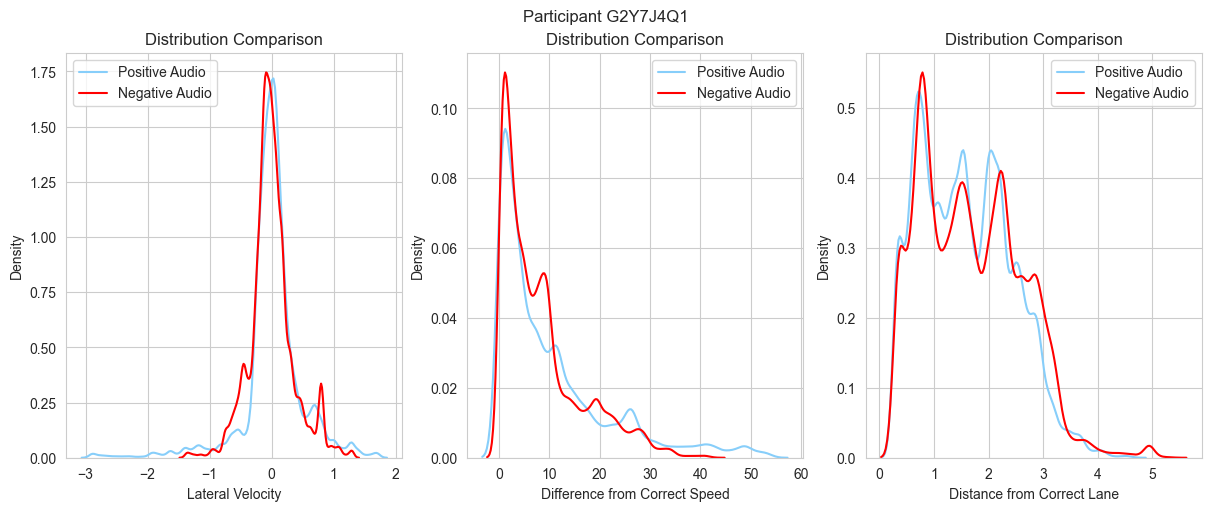

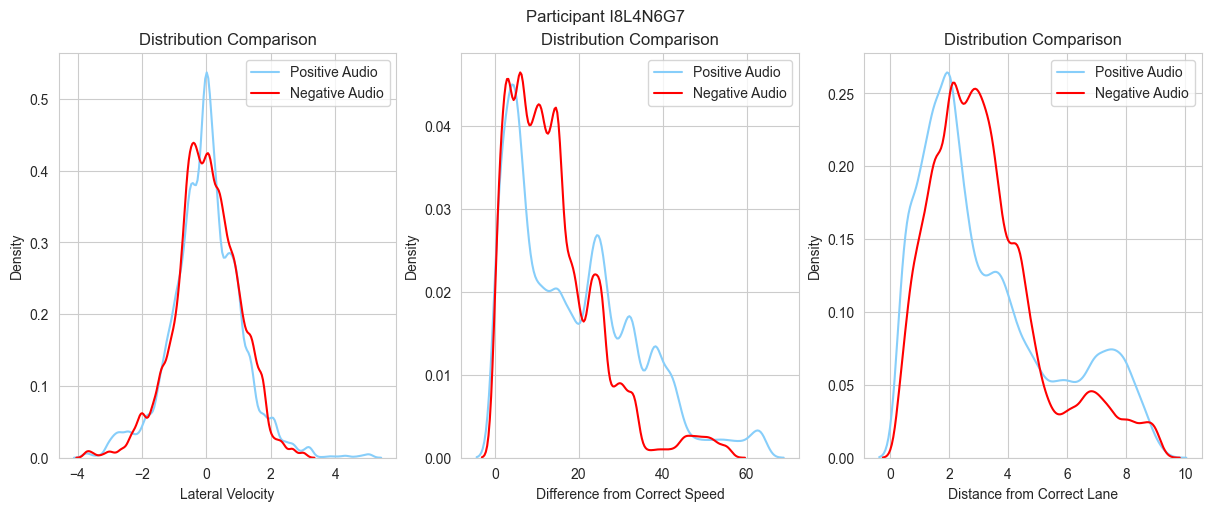

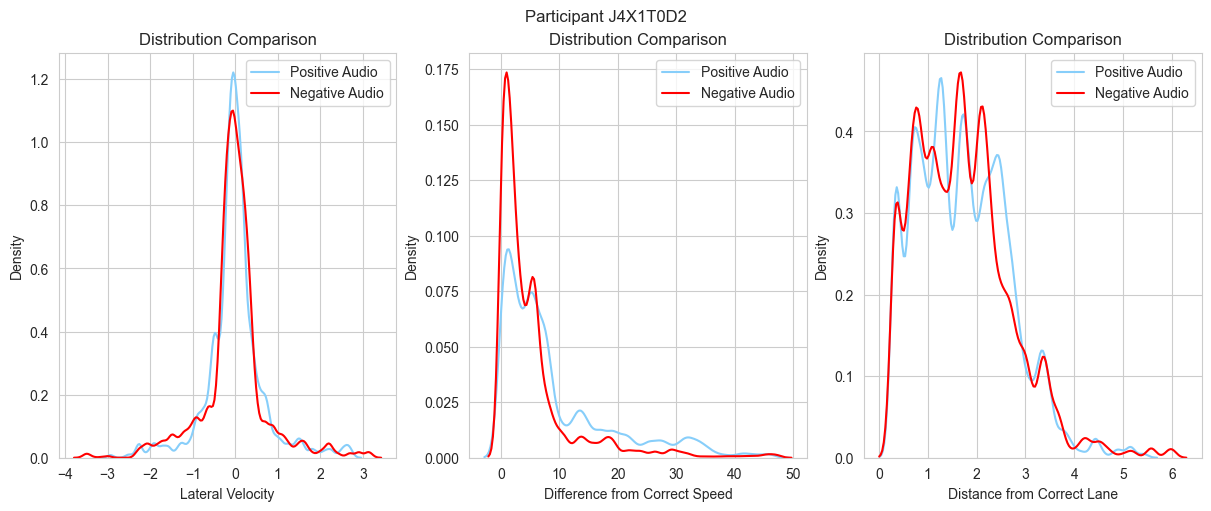

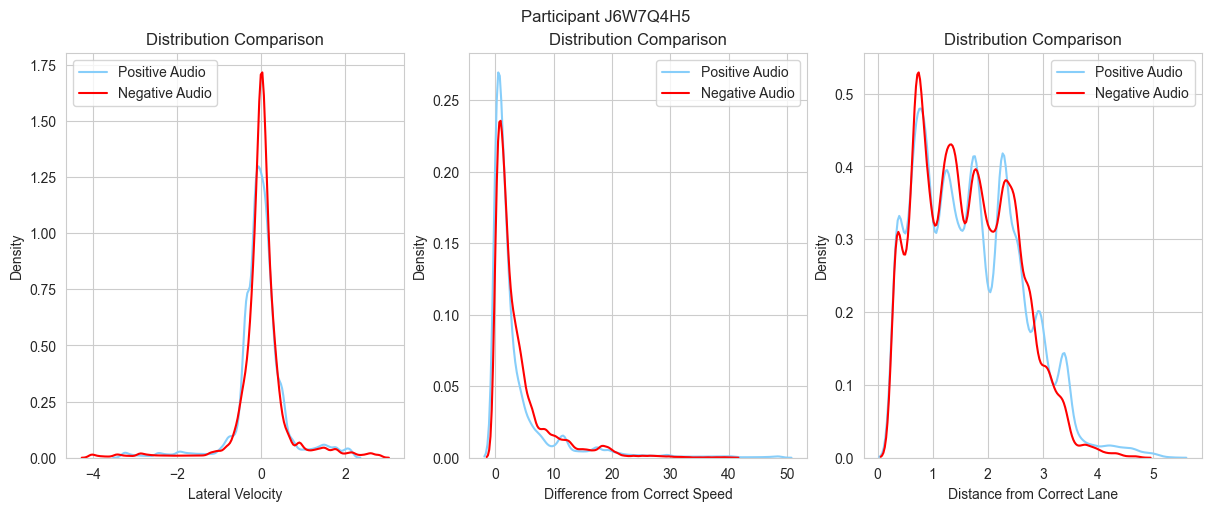

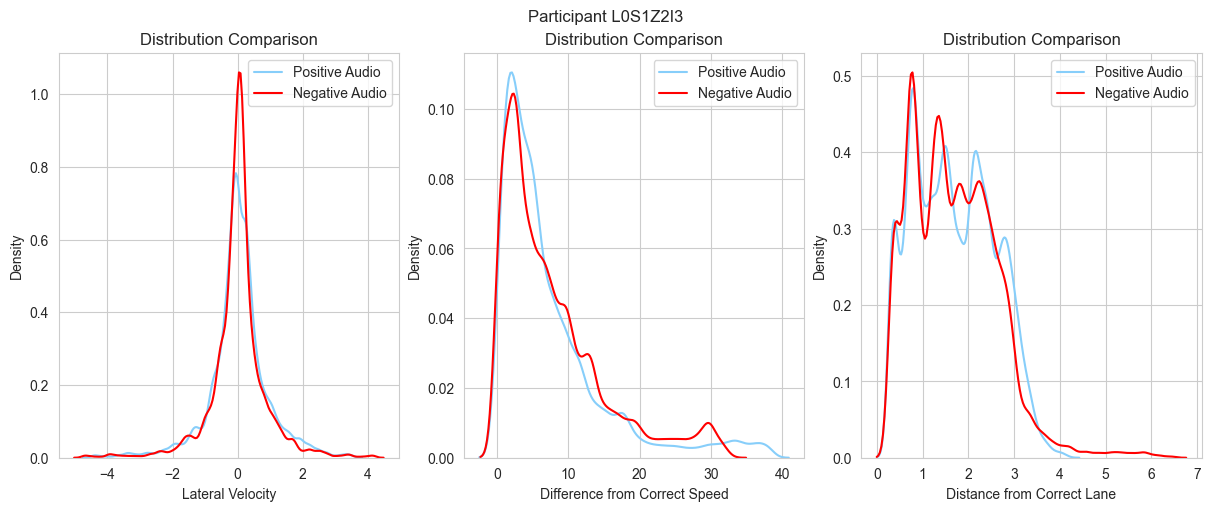

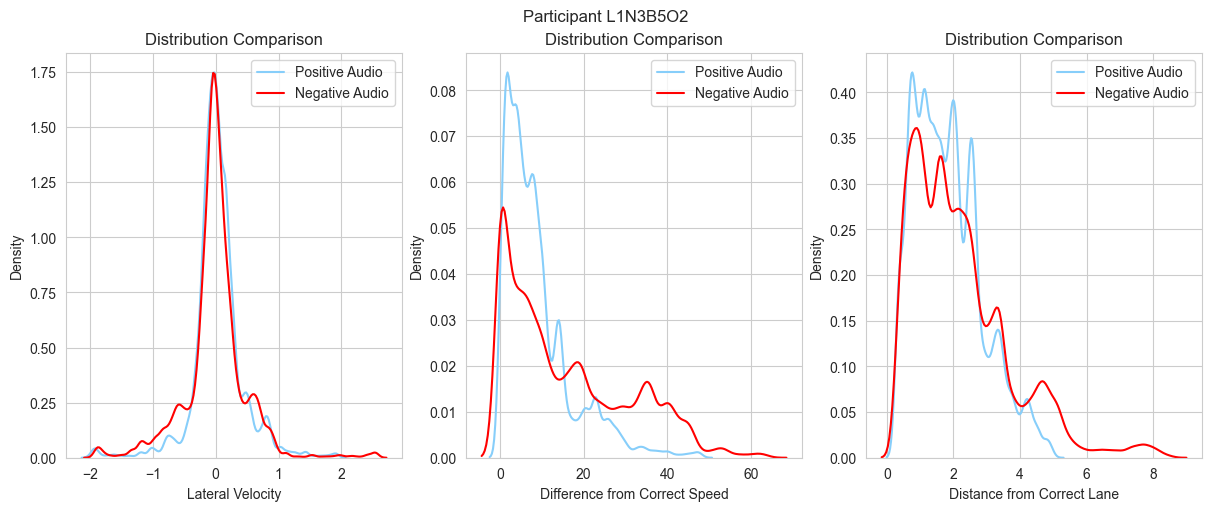

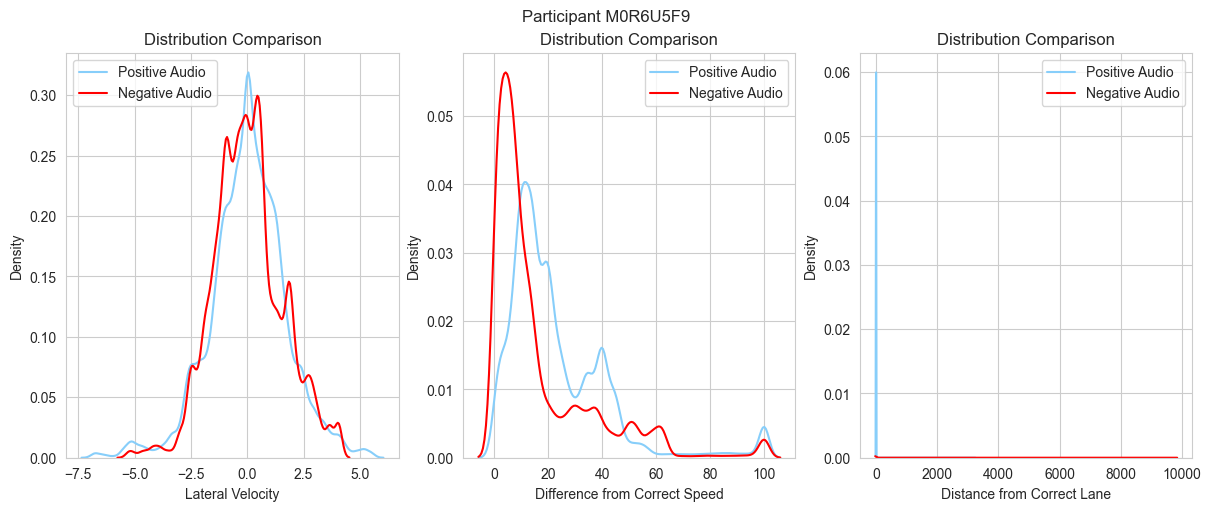

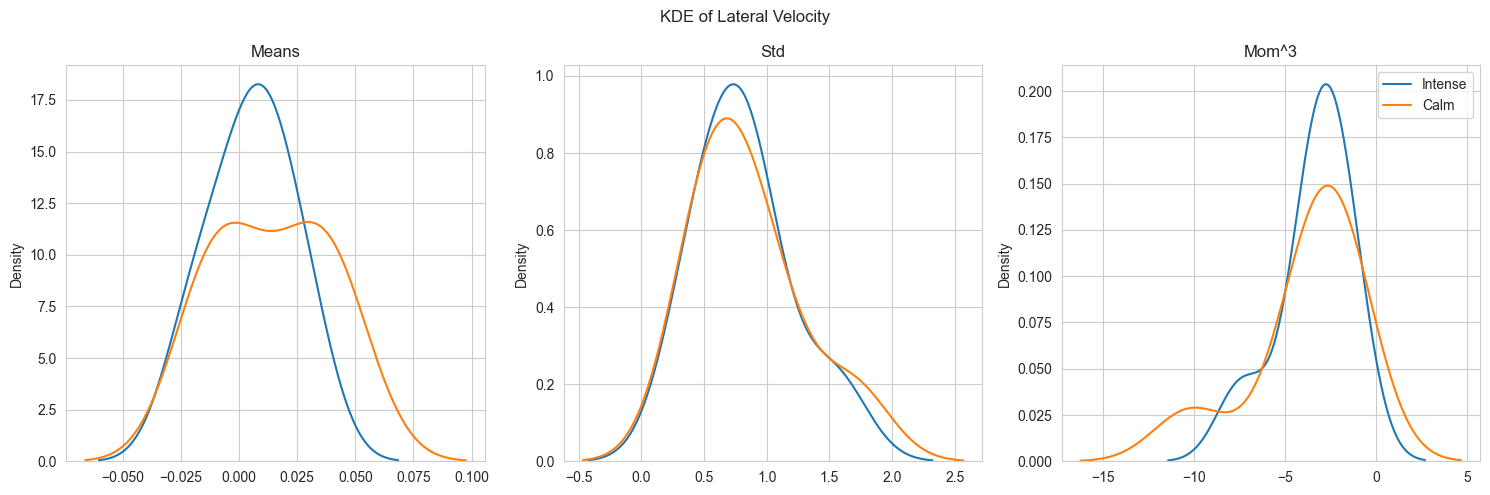

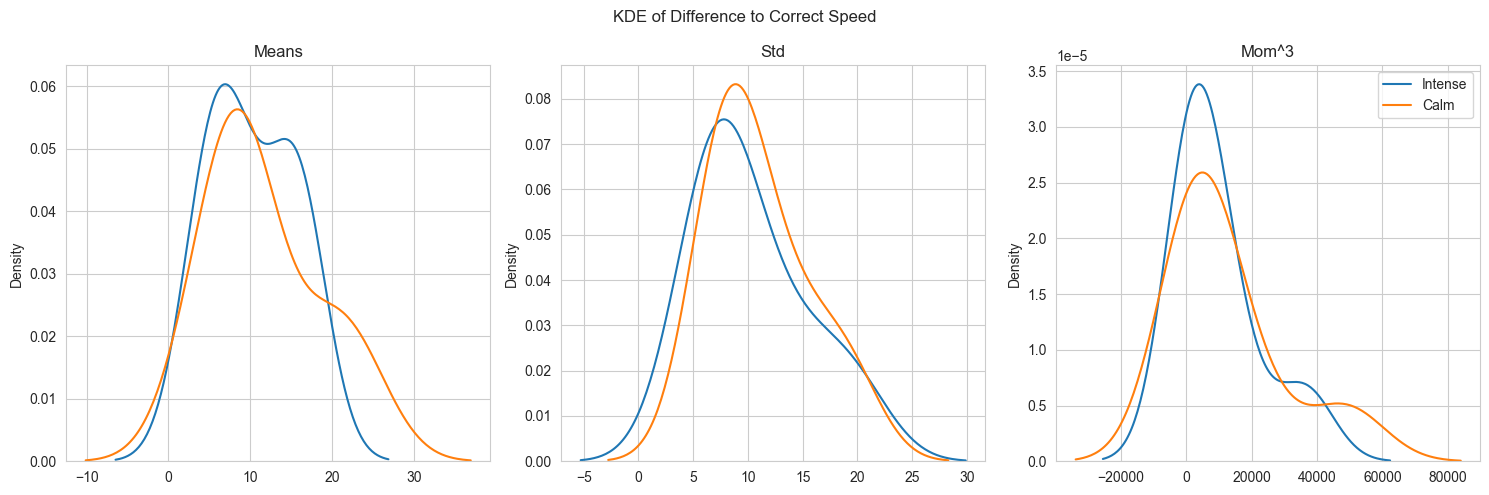

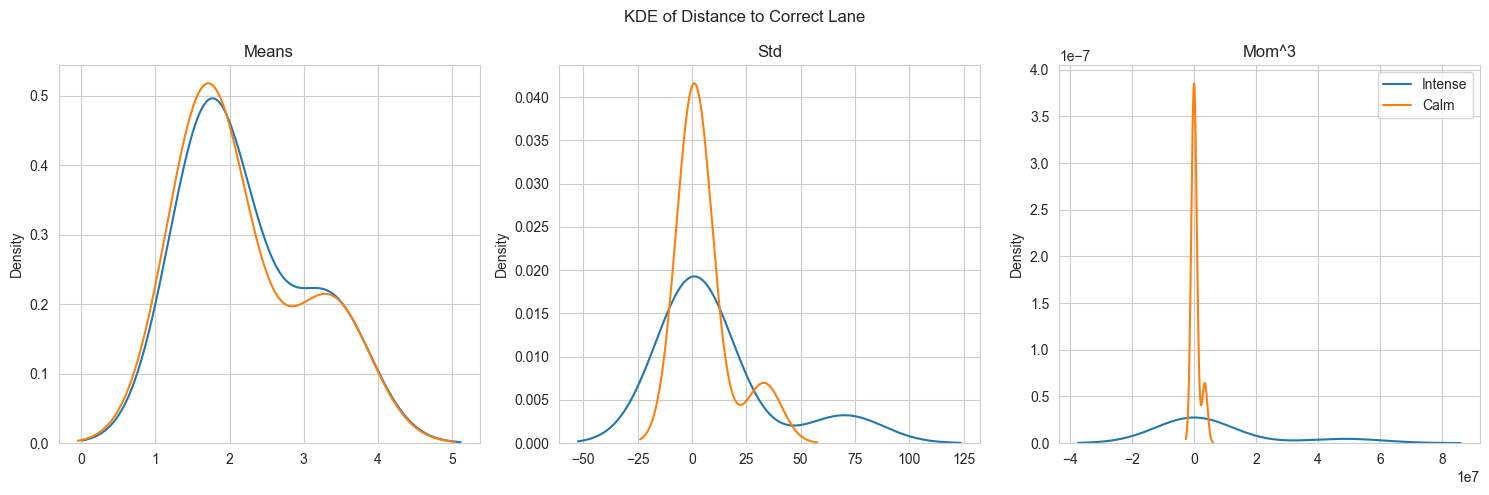

In [ ]:
calm_man, intense_man = get_all_stats(drop_gender='MALE')
dataset_man = generate_datasets(calm_stats=calm_man, intense_stats=intense_man, pairs=pairs)
plot_all_perf_param_kdes(datasets=dataset_man, titles=titles)

In [ ]:
for j, (intense, calm) in enumerate(dataset_man_outl):
    print(f'\nT-test results for {titles[j]}, intense vs calm:')
    print(f'Means: {ttest_rel([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {ttest_rel([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {ttest_rel([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')


T-test results for Lateral Velocity, intense vs calm:
Means: 0.21455779259860913
STDs: 0.9025188083563968
Mom^3s: 0.21621606147147773

T-test results for Difference to Correct Speed, intense vs calm:
Means: 0.6942613370824889
STDs: 0.9928126694093327
Mom^3s: 0.7883550968788549

T-test results for Distance to Correct Lane, intense vs calm:
Means: 0.8597781195951577
STDs: 0.8554482696474912
Mom^3s: 0.6685909656924475


##### With outliers removed

['C1K4L9S8', 'D0P7X9W6', 'G2Y7J4Q1', 'G9K4W1Z0', 'I8L4N6G7', 'J4X1T0D2', 'J6W7Q4H5', 'K4G7Y9O2', 'L0S1Z2I3', 'L1N3B5O2', 'M0R6U5F9', 'M4H6R2W9', 'M7D3F5K4', 'N7P5B8G0', 'O4A0U8R1', 'R0V9G1L4', 'U6O5V2T9', 'V9L0P2K7', 'X5Q0G4J2', 'Z6A2W1E8']
C1K4L9S8 OK
Skipping C1K4L9S8 cause of gender
D0P7X9W6 OK
Skipping D0P7X9W6 cause of gender
G2Y7J4Q1 OK
G9K4W1Z0 OK
Skipping G9K4W1Z0 cause of gender
I8L4N6G7 OK
J4X1T0D2 OK
J6W7Q4H5 OK
K4G7Y9O2 OK
Skipping K4G7Y9O2 cause of gender
L0S1Z2I3 OK
L1N3B5O2 OK
M0R6U5F9 OK
M4H6R2W9 OK
Skipping M4H6R2W9 cause of gender
M7D3F5K4 OK
Skipping M7D3F5K4 cause of gender
N7P5B8G0 OK
Skipping N7P5B8G0 cause of gender
O4A0U8R1 OK
Skipping O4A0U8R1 cause of gender
R0V9G1L4 FAIL
U6O5V2T9 OK
Skipping U6O5V2T9 cause of gender
V9L0P2K7 OK
Skipping V9L0P2K7 cause of gender
X5Q0G4J2 OK
Skipping X5Q0G4J2 cause of gender
Z6A2W1E8 OK
Skipping Z6A2W1E8 cause of gender


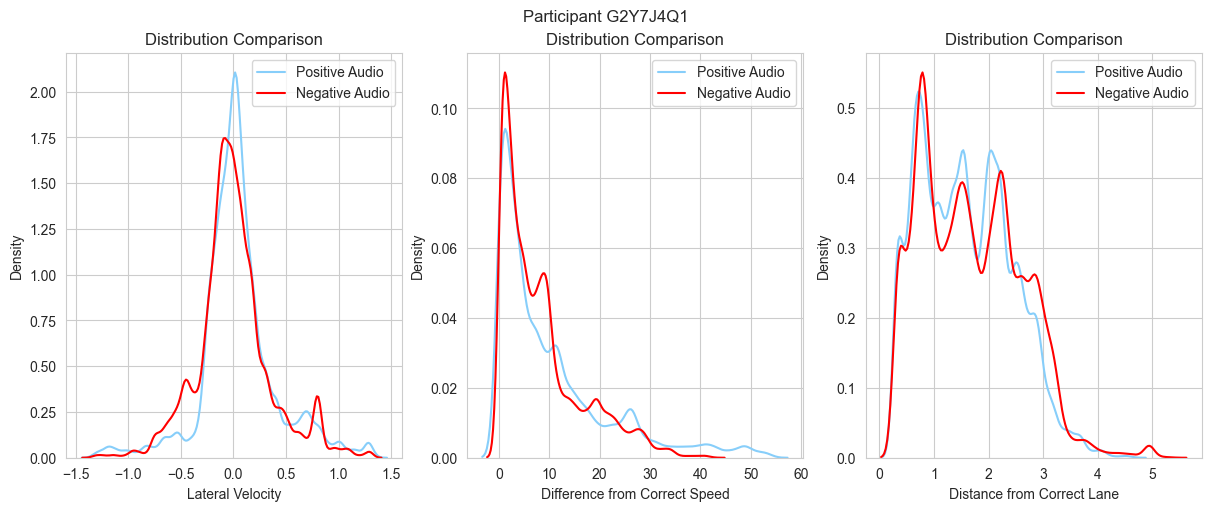

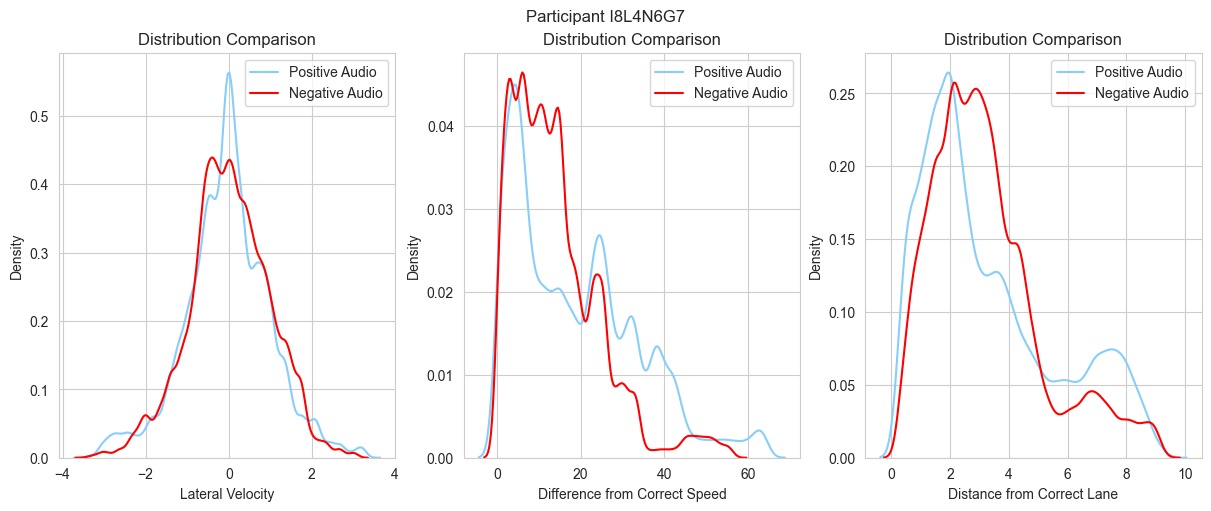

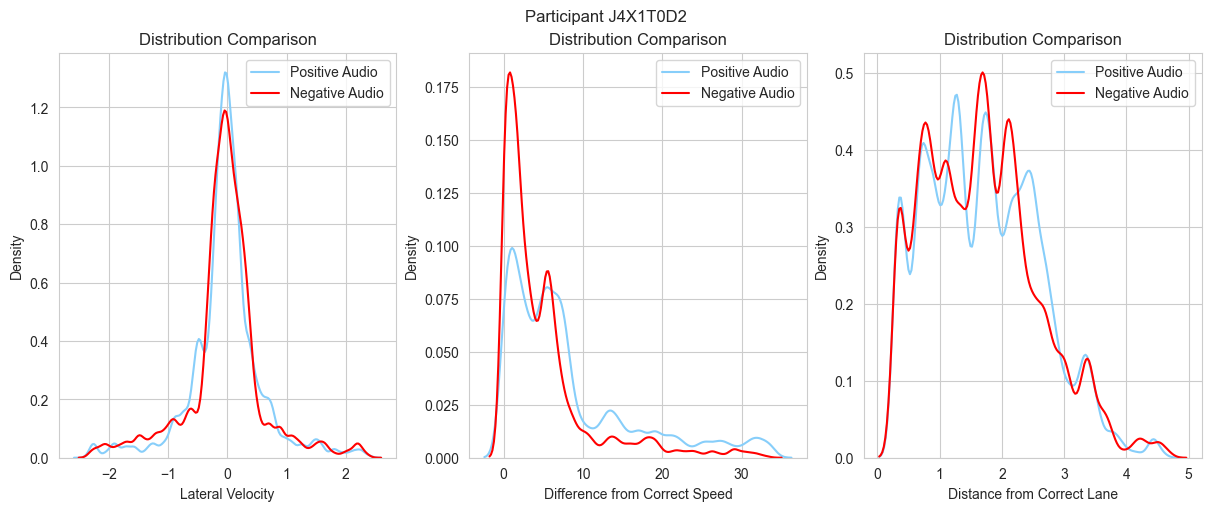

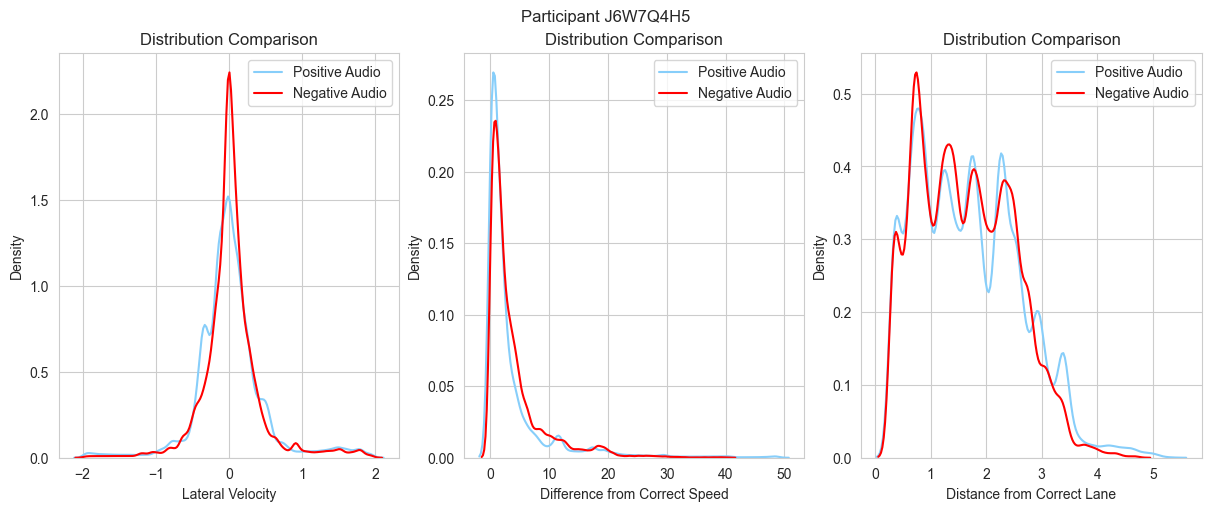

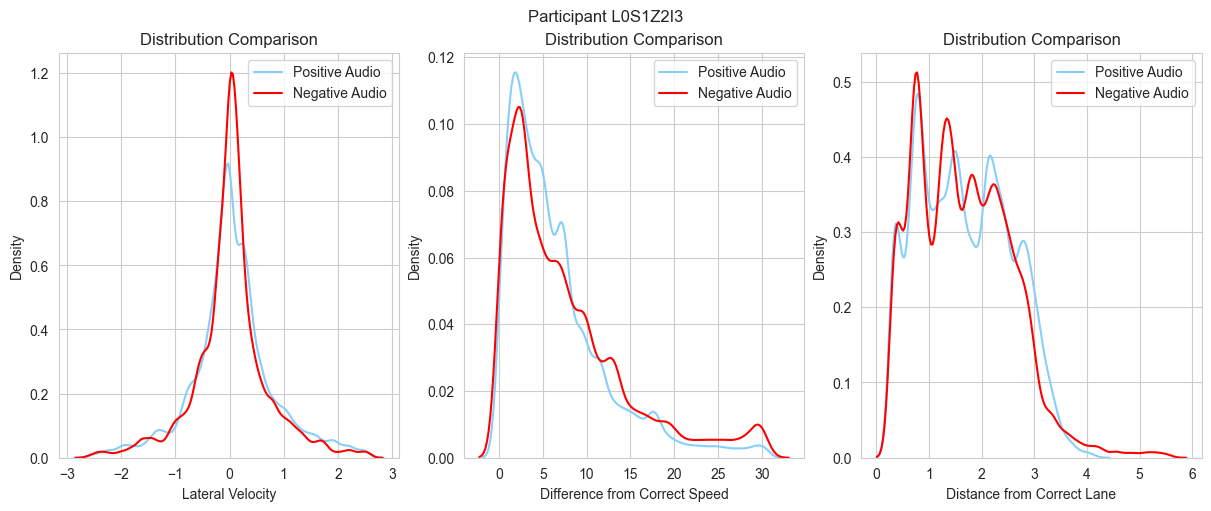

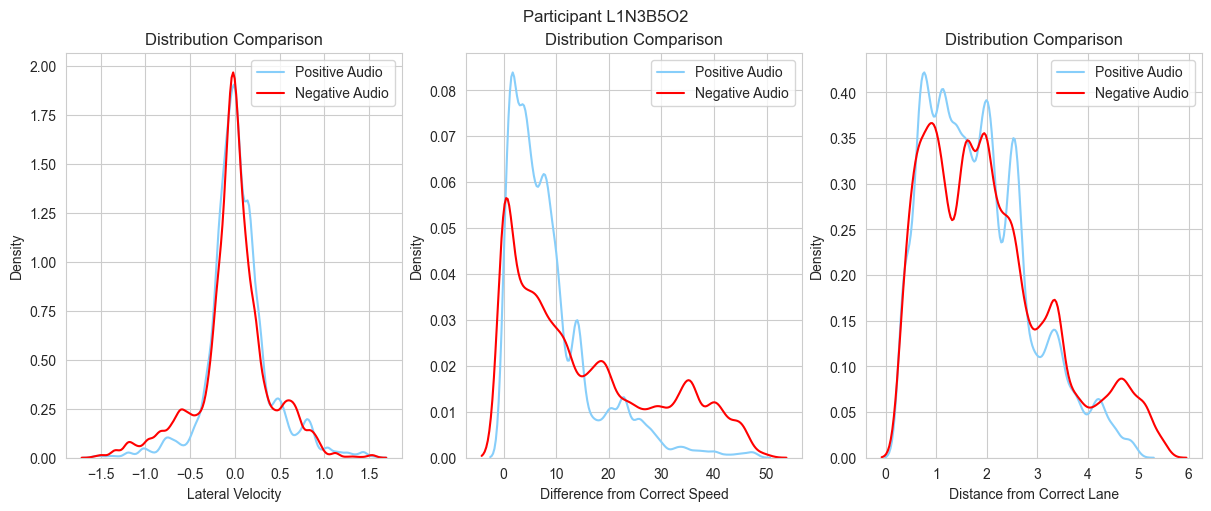

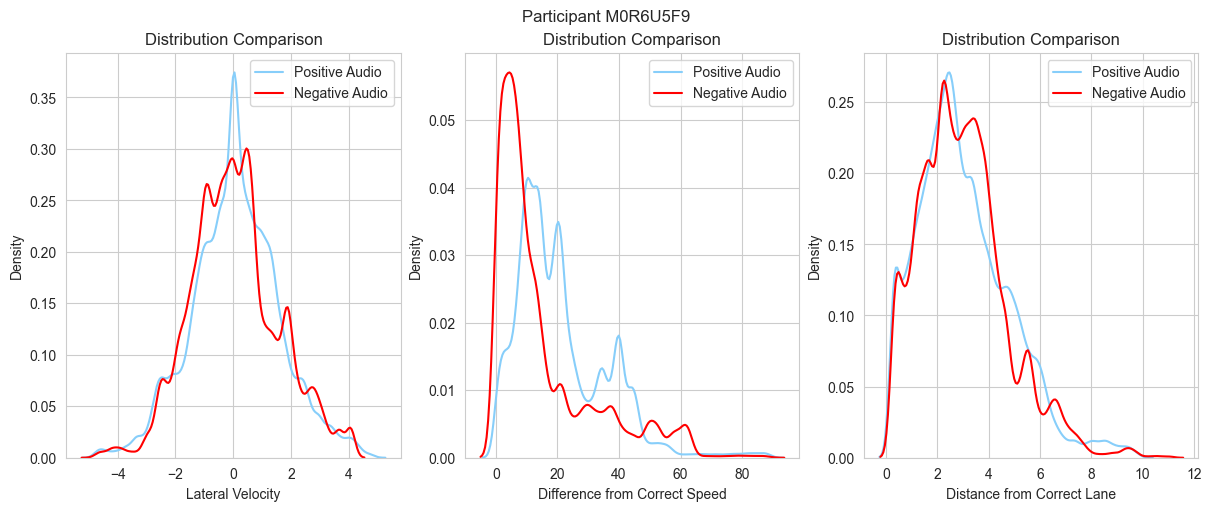

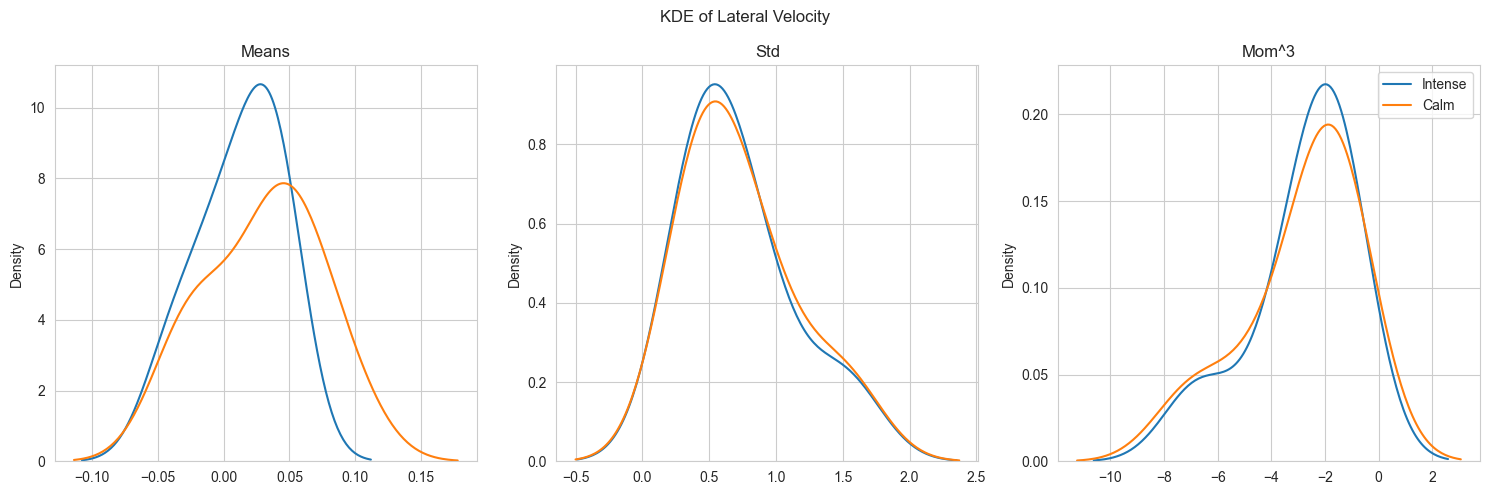

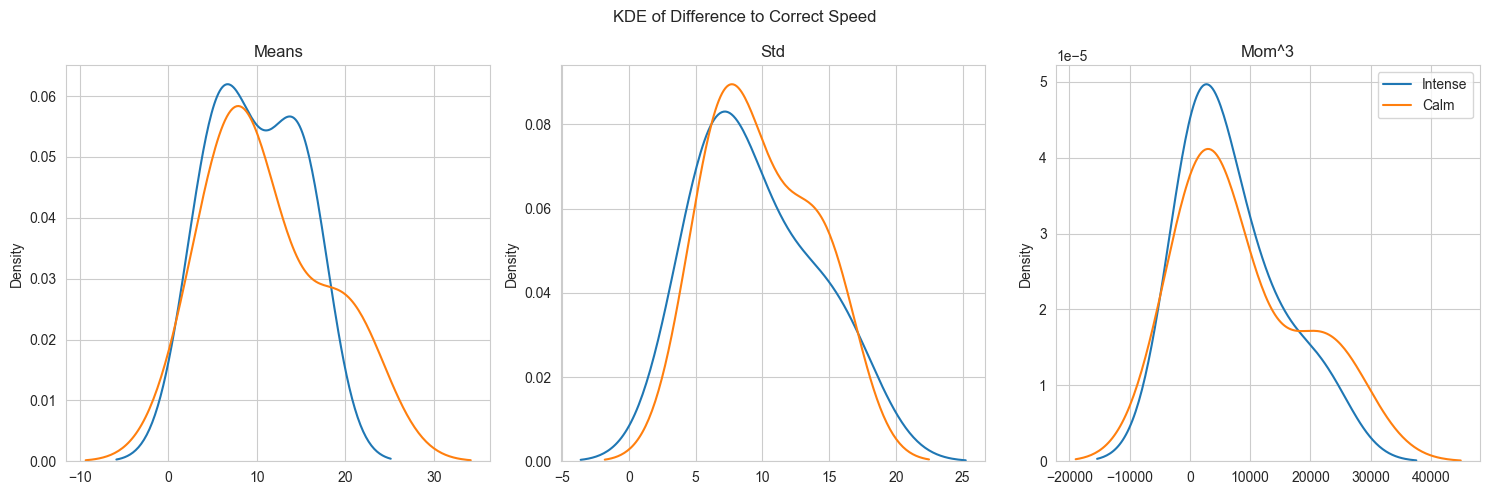

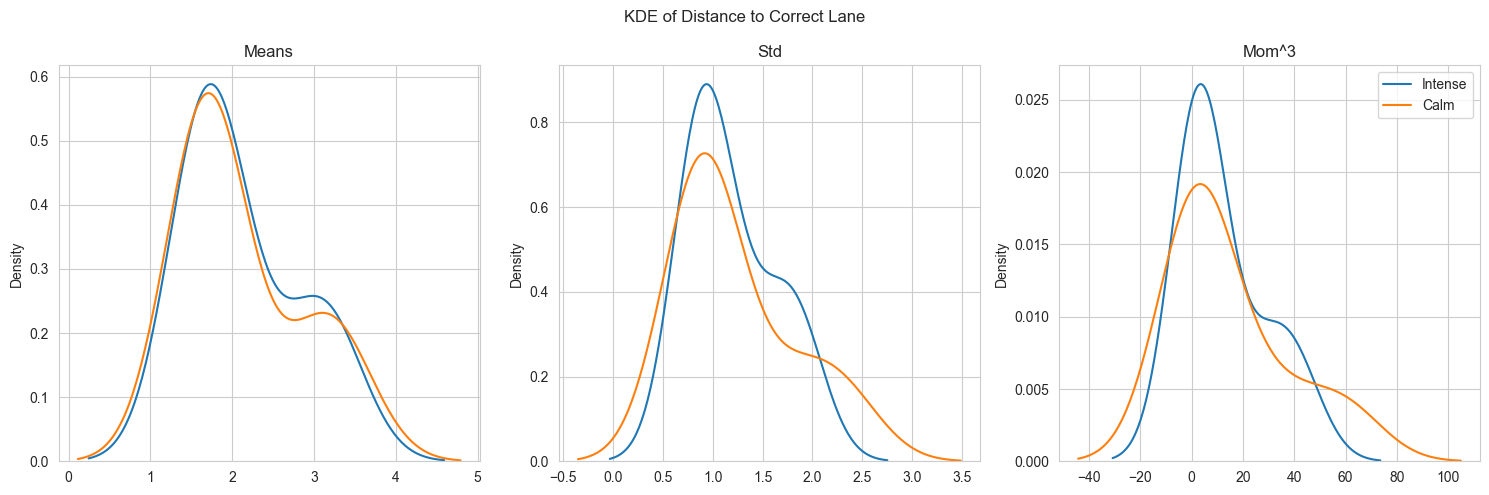

In [ ]:
calm_man_outl, intense_man_outl = get_all_stats(drop_gender='MALE',remove_outliers=['VelocityX', 'DistanceToTargetPosition', 'DistanceToTargetSpeed'])
dataset_man_outl = generate_datasets(calm_stats=calm_man_outl, intense_stats=intense_man_outl, pairs=pairs)
plot_all_perf_param_kdes(datasets=dataset_man_outl, titles=titles)

In [ ]:
for j, (intense, calm) in enumerate(dataset_man_outl):
    print(f'\nT-test results for {titles[j]}, intense vs calm:')
    print(f'Means: {ttest_rel([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {ttest_rel([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {ttest_rel([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')


T-test results for Lateral Velocity, intense vs calm:
Means: 0.257723898374721
STDs: 0.4108794815425716
Mom^3s: 0.5511735750053153

T-test results for Difference to Correct Speed, intense vs calm:
Means: 0.46355864336259633
STDs: 0.7615612909959384
Mom^3s: 0.5127204896624613

T-test results for Distance to Correct Lane, intense vs calm:
Means: 0.8640353113177037
STDs: 0.6377910003602814
Mom^3s: 0.3909064506267478


### Analyzing ordering effect

#### PN 

['C1K4L9S8', 'D0P7X9W6', 'G2Y7J4Q1', 'G9K4W1Z0', 'I8L4N6G7', 'J4X1T0D2', 'J6W7Q4H5', 'K4G7Y9O2', 'L0S1Z2I3', 'L1N3B5O2', 'M0R6U5F9', 'M4H6R2W9', 'M7D3F5K4', 'N7P5B8G0', 'O4A0U8R1', 'R0V9G1L4', 'U6O5V2T9', 'V9L0P2K7', 'X5Q0G4J2', 'Z6A2W1E8']
C1K4L9S8 OK
Skipping C1K4L9S8 cause of order
D0P7X9W6 OK
G2Y7J4Q1 OK
G9K4W1Z0 OK
I8L4N6G7 OK
J4X1T0D2 OK
J6W7Q4H5 OK
Skipping J6W7Q4H5 cause of order
K4G7Y9O2 OK
Skipping K4G7Y9O2 cause of order
L0S1Z2I3 OK
Skipping L0S1Z2I3 cause of order
L1N3B5O2 OK
Skipping L1N3B5O2 cause of order
M0R6U5F9 OK
M4H6R2W9 OK
Skipping M4H6R2W9 cause of order
M7D3F5K4 OK
N7P5B8G0 OK
O4A0U8R1 OK
Skipping O4A0U8R1 cause of order
R0V9G1L4 FAIL
U6O5V2T9 OK
Skipping U6O5V2T9 cause of order
V9L0P2K7 OK
X5Q0G4J2 OK
Skipping X5Q0G4J2 cause of order
Z6A2W1E8 OK


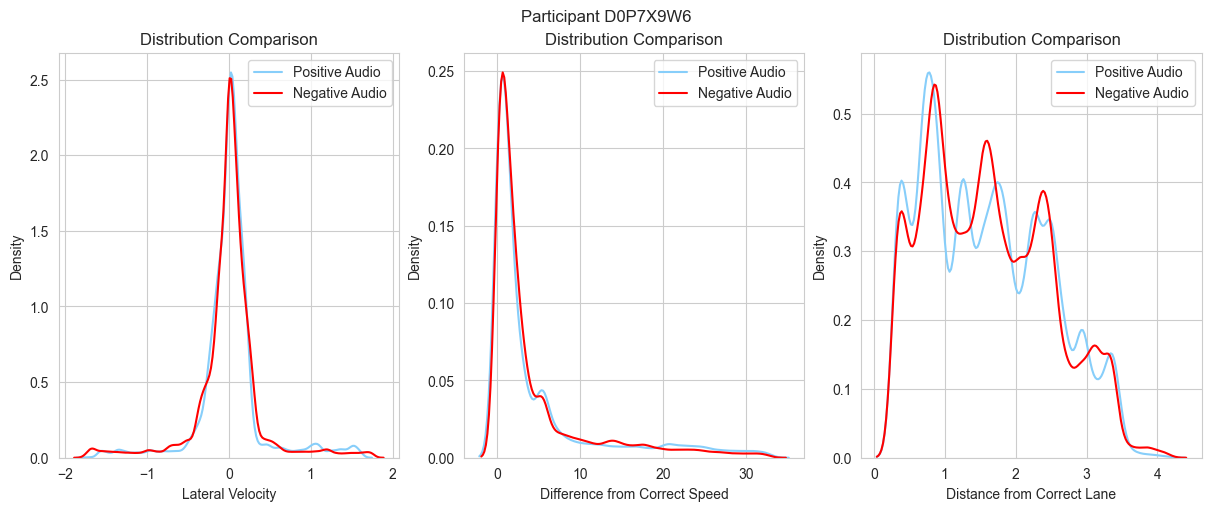

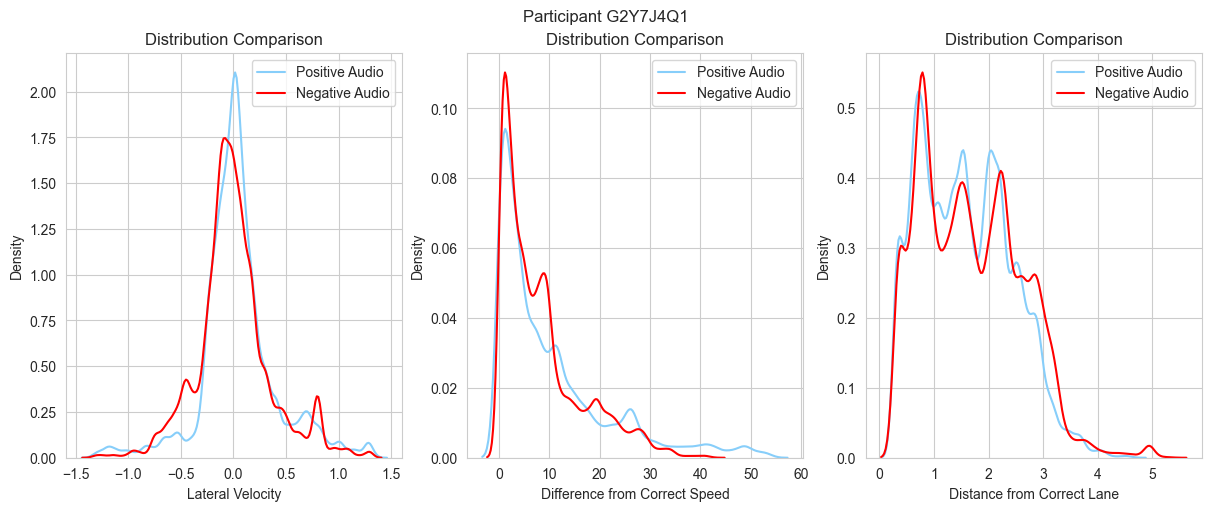

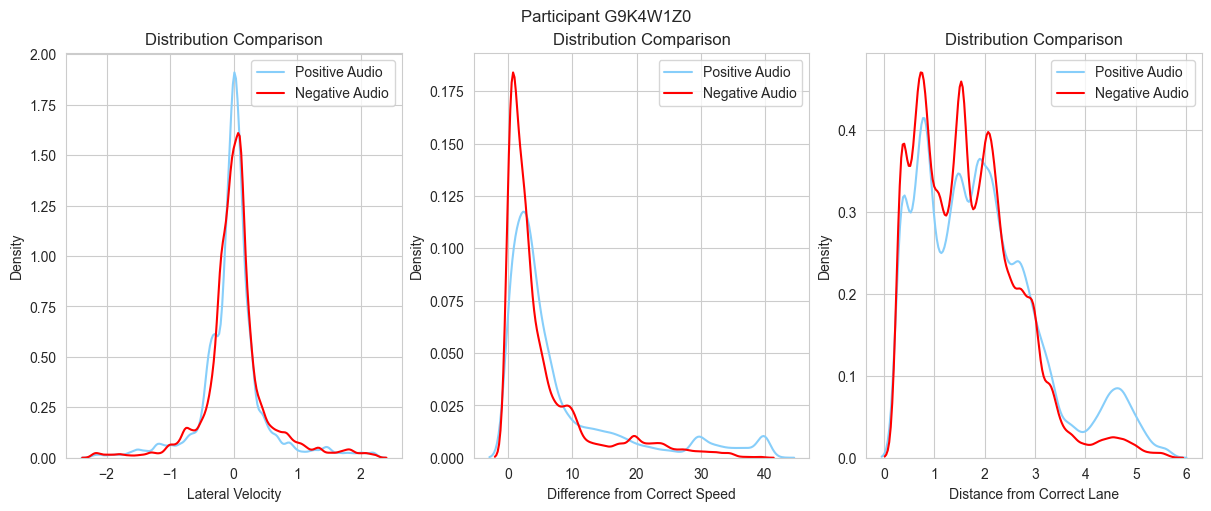

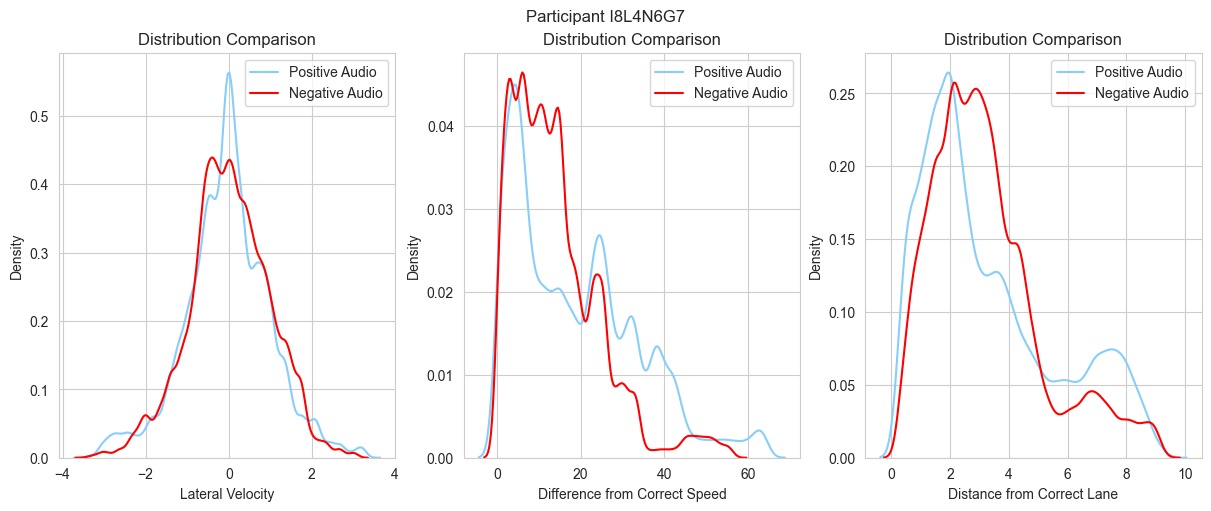

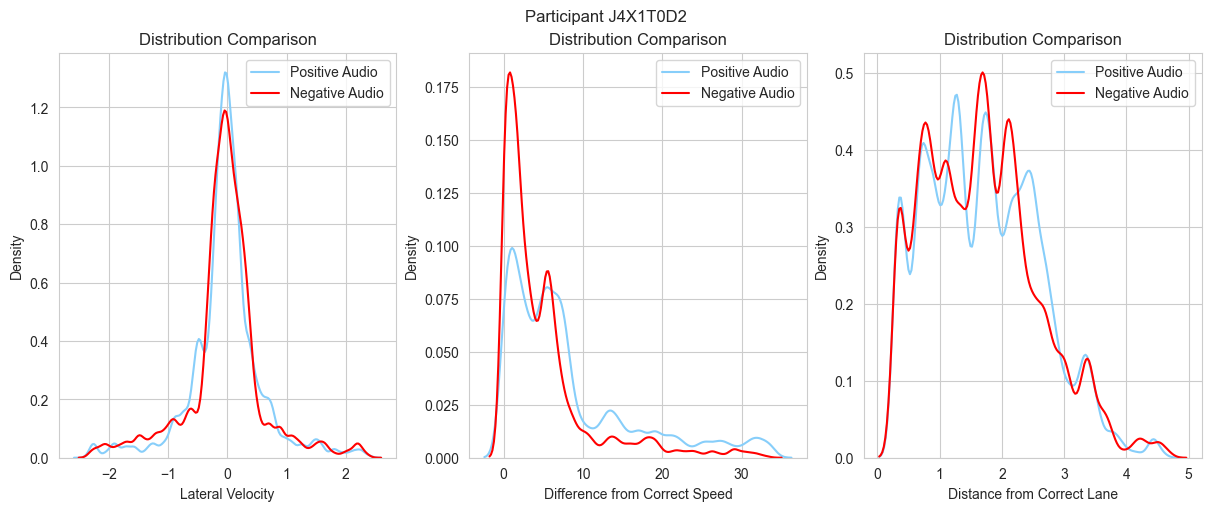

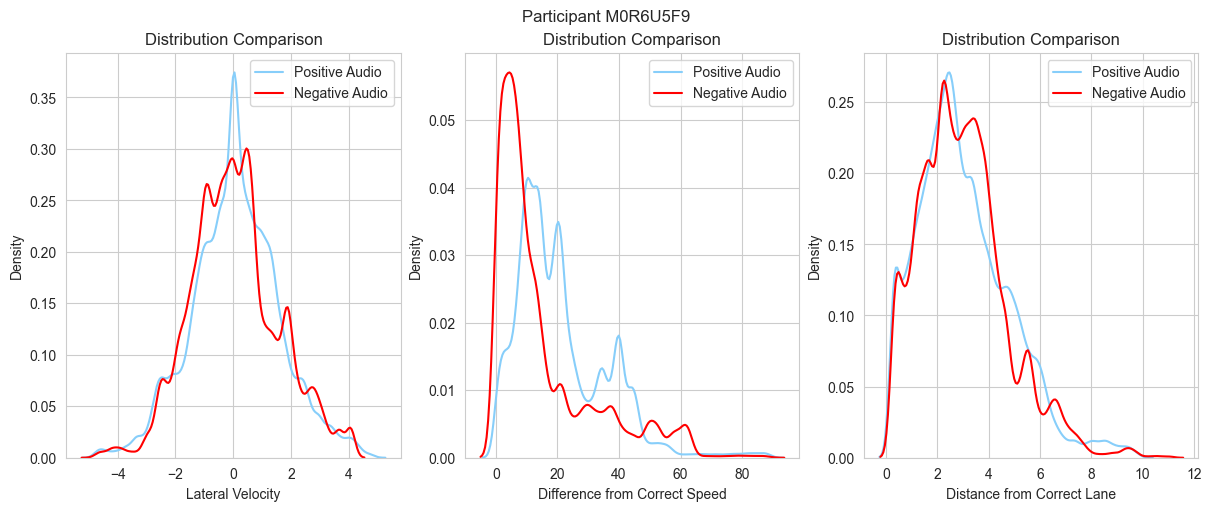

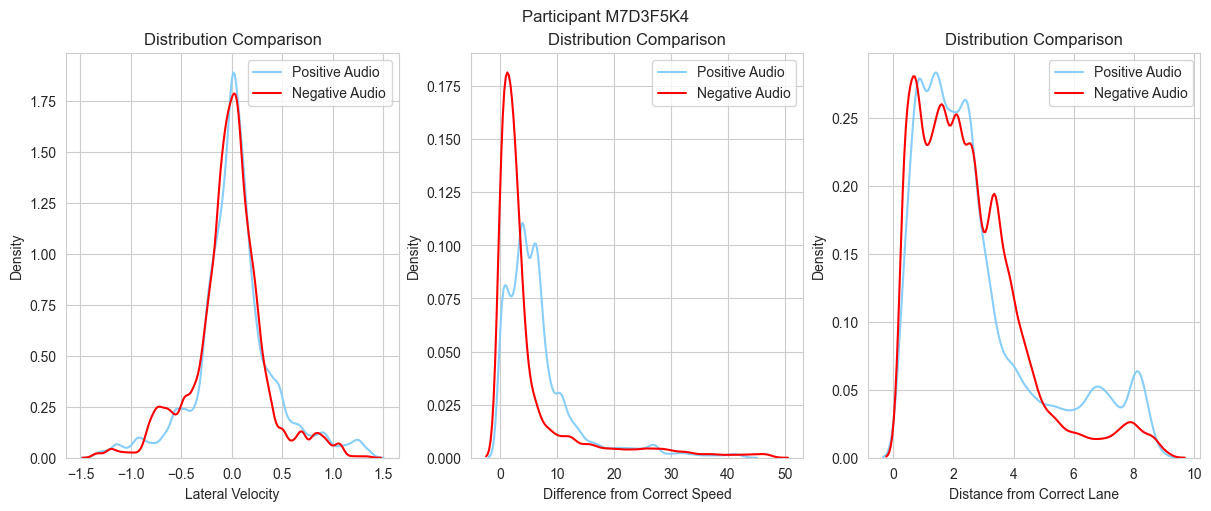

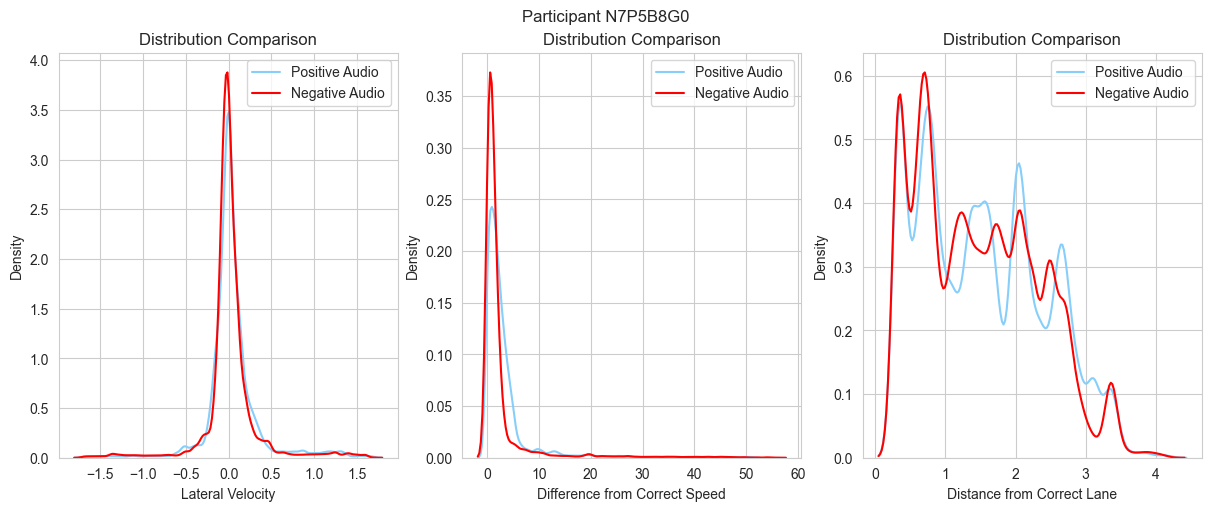

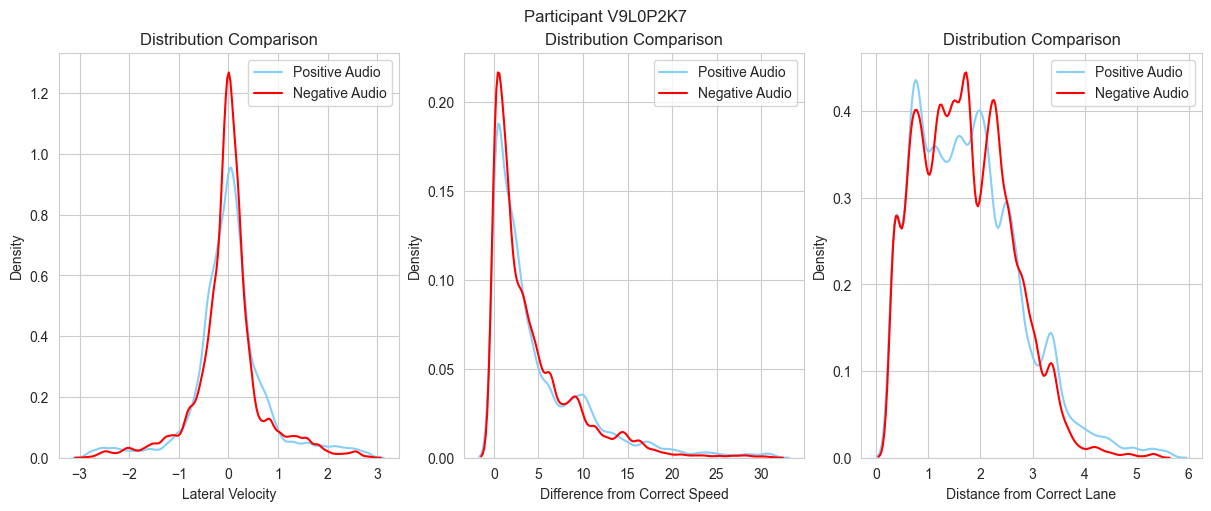

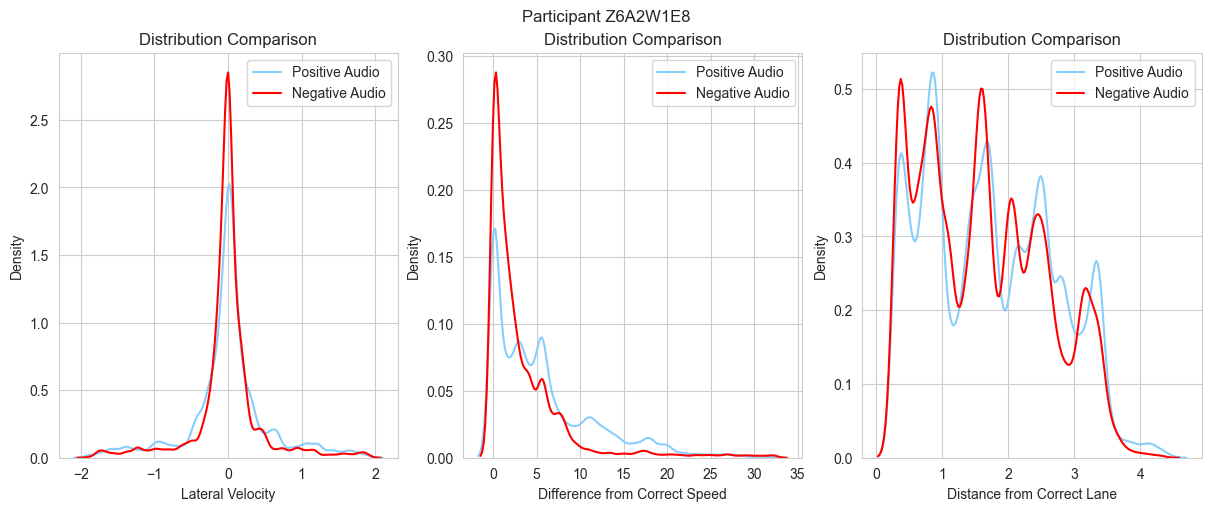

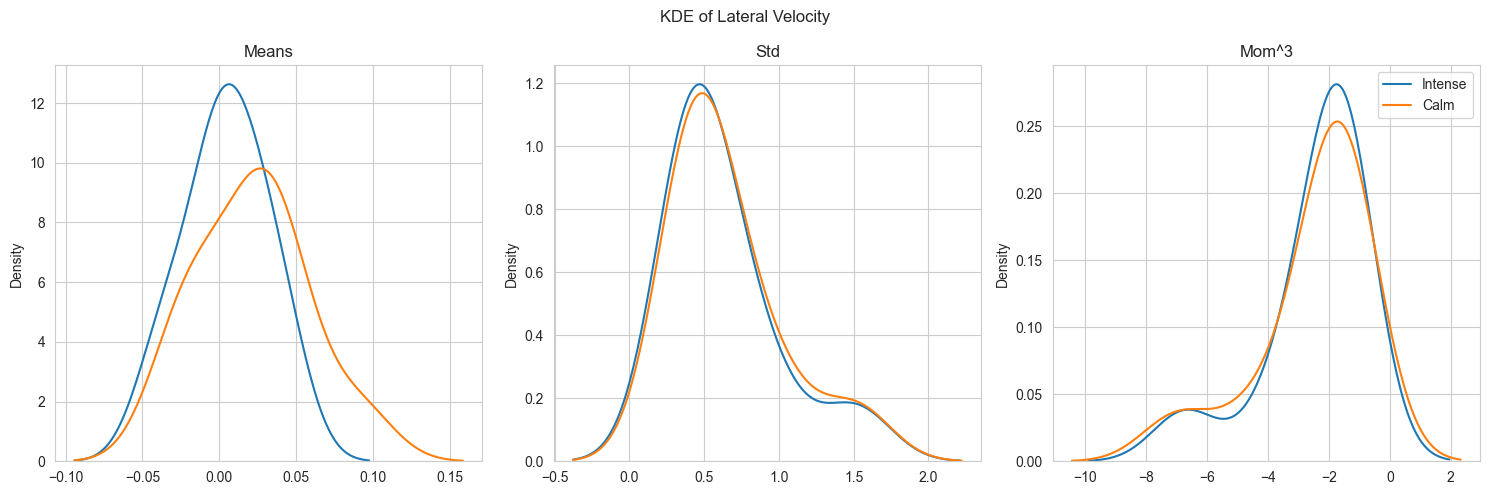

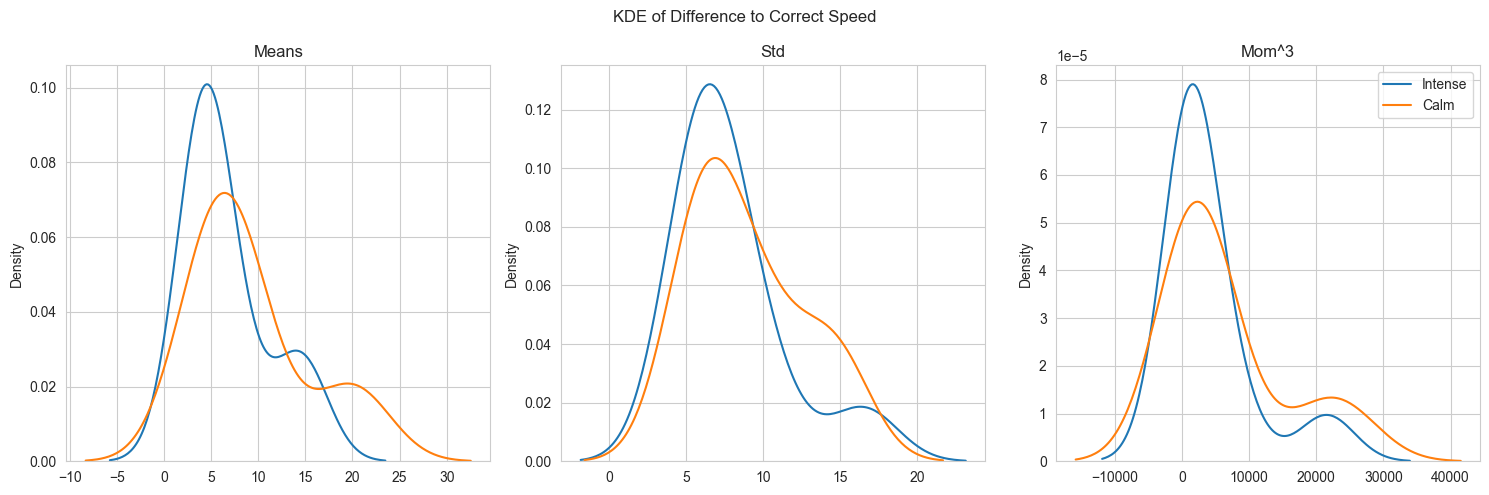

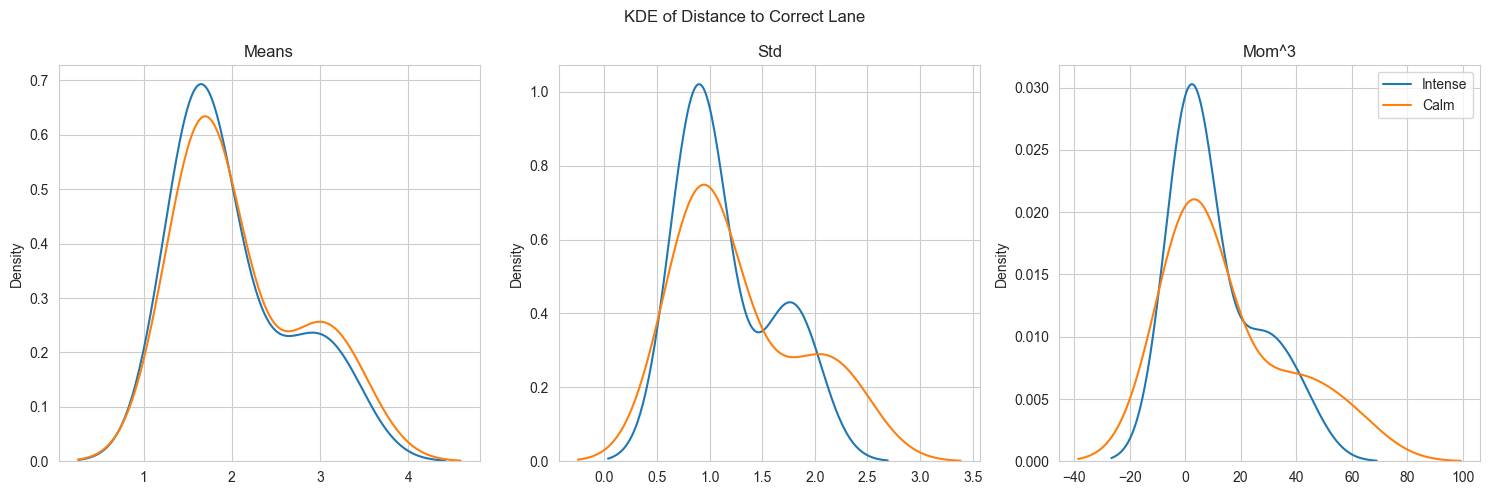

In [ ]:
calm_pn, intense_pn = get_all_stats(drop_order='NP', remove_outliers=['VelocityX', 'DistanceToTargetPosition', 'DistanceToTargetSpeed'])
dataset_pn = generate_datasets(calm_stats=calm_pn, intense_stats=intense_pn, pairs=pairs)
plot_all_perf_param_kdes(datasets=dataset_pn, titles=titles)

In [ ]:
from scipy.stats import kruskal
for j, (intense, calm) in enumerate(dataset_pn):
    print(f'\nT-test results for {titles[j]}, intense vs calm:')
    print(f'Means: {ttest_rel([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {ttest_rel([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {ttest_rel([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')
    print(f'\nKruskal results for {titles[j]}, intense vs calm:')
    print(f'Means: {kruskal([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {kruskal([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {kruskal([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')


T-test results for Lateral Velocity, intense vs calm:
Means: 0.15226117407634776
STDs: 0.11007925873311876
Mom^3s: 0.3714016998386561

Kruskal results for Lateral Velocity, intense vs calm:
Means: 0.22647606604348455
STDs: 0.7623688184698474
Mom^3s: 1.0

T-test results for Difference to Correct Speed, intense vs calm:
Means: 0.0024509959079302515
STDs: 0.12590225181239437
Mom^3s: 0.07732116416357587

Kruskal results for Difference to Correct Speed, intense vs calm:
Means: 0.22647606604348455
STDs: 0.4496917979688917
Mom^3s: 0.4496917979688917

T-test results for Distance to Correct Lane, intense vs calm:
Means: 0.046155774177329995
STDs: 0.045667990277228517
Mom^3s: 0.08942129158753905

Kruskal results for Distance to Correct Lane, intense vs calm:
Means: 0.5967012167293555
STDs: 0.5967012167293555
Mom^3s: 0.6501474440948595


#### NP

['C1K4L9S8', 'D0P7X9W6', 'G2Y7J4Q1', 'G9K4W1Z0', 'I8L4N6G7', 'J4X1T0D2', 'J6W7Q4H5', 'K4G7Y9O2', 'L0S1Z2I3', 'L1N3B5O2', 'M0R6U5F9', 'M4H6R2W9', 'M7D3F5K4', 'N7P5B8G0', 'O4A0U8R1', 'R0V9G1L4', 'U6O5V2T9', 'V9L0P2K7', 'X5Q0G4J2', 'Z6A2W1E8']
C1K4L9S8 OK
D0P7X9W6 OK
Skipping D0P7X9W6 cause of order
G2Y7J4Q1 OK
Skipping G2Y7J4Q1 cause of order
G9K4W1Z0 OK
Skipping G9K4W1Z0 cause of order
I8L4N6G7 OK
Skipping I8L4N6G7 cause of order
J4X1T0D2 OK
Skipping J4X1T0D2 cause of order
J6W7Q4H5 OK
K4G7Y9O2 OK
L0S1Z2I3 OK
L1N3B5O2 OK
M0R6U5F9 OK
Skipping M0R6U5F9 cause of order
M4H6R2W9 OK
M7D3F5K4 OK
Skipping M7D3F5K4 cause of order
N7P5B8G0 OK
Skipping N7P5B8G0 cause of order
O4A0U8R1 OK
R0V9G1L4 FAIL
U6O5V2T9 OK
V9L0P2K7 OK
Skipping V9L0P2K7 cause of order
X5Q0G4J2 OK
Z6A2W1E8 OK
Skipping Z6A2W1E8 cause of order


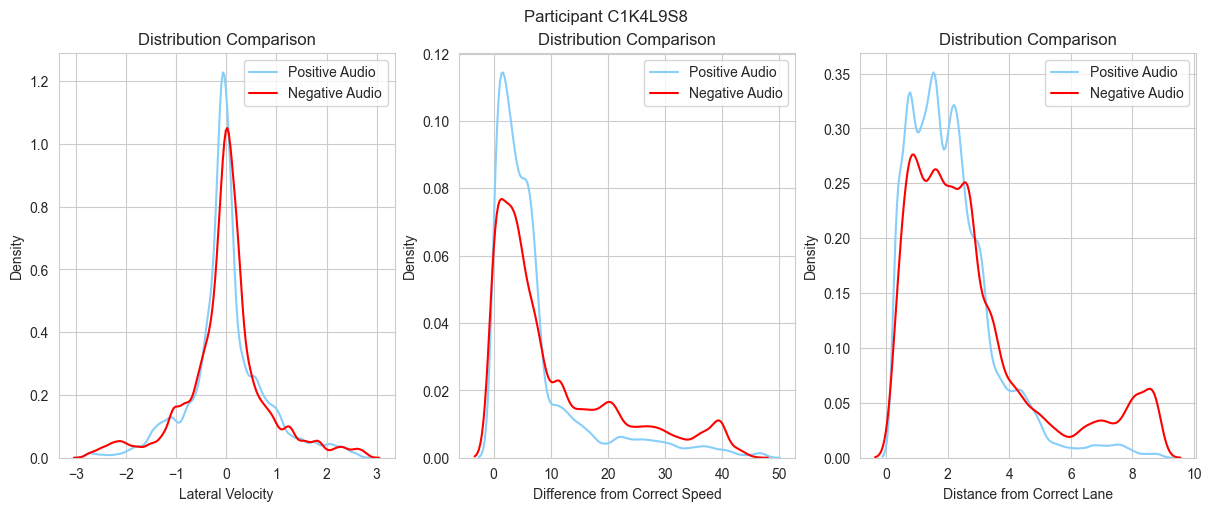

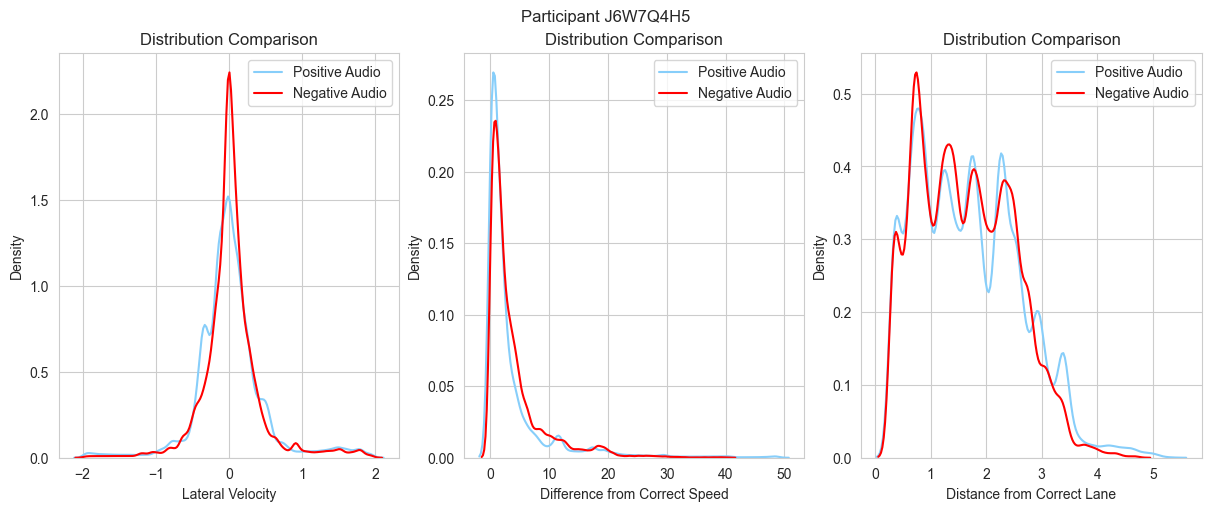

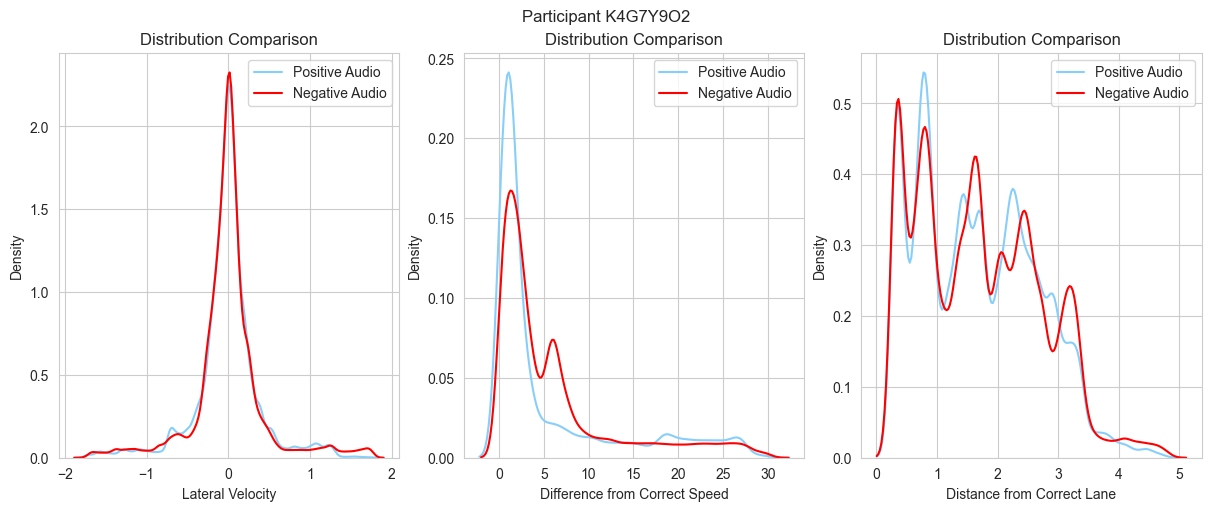

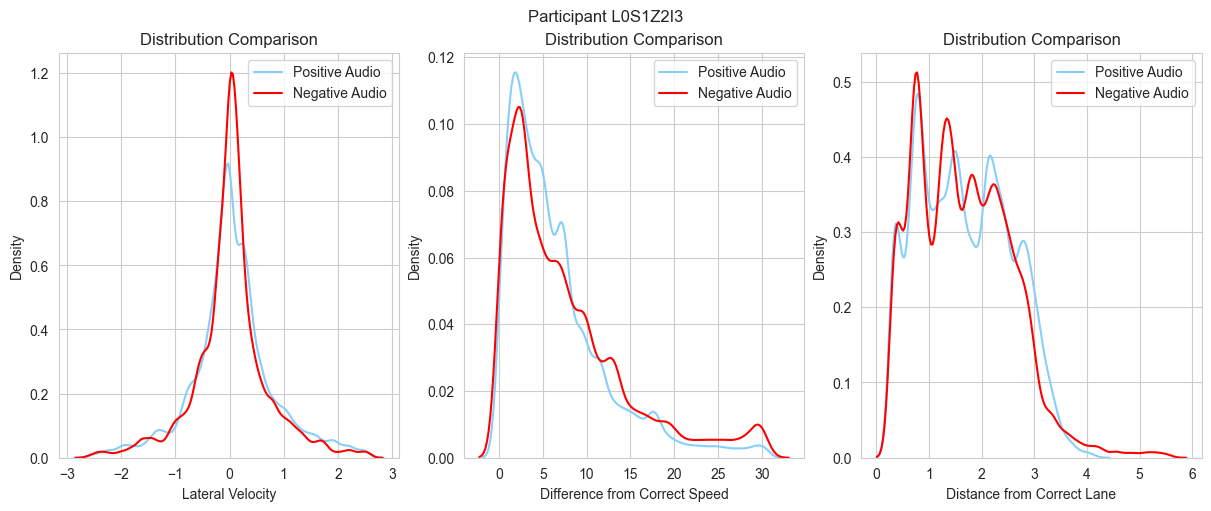

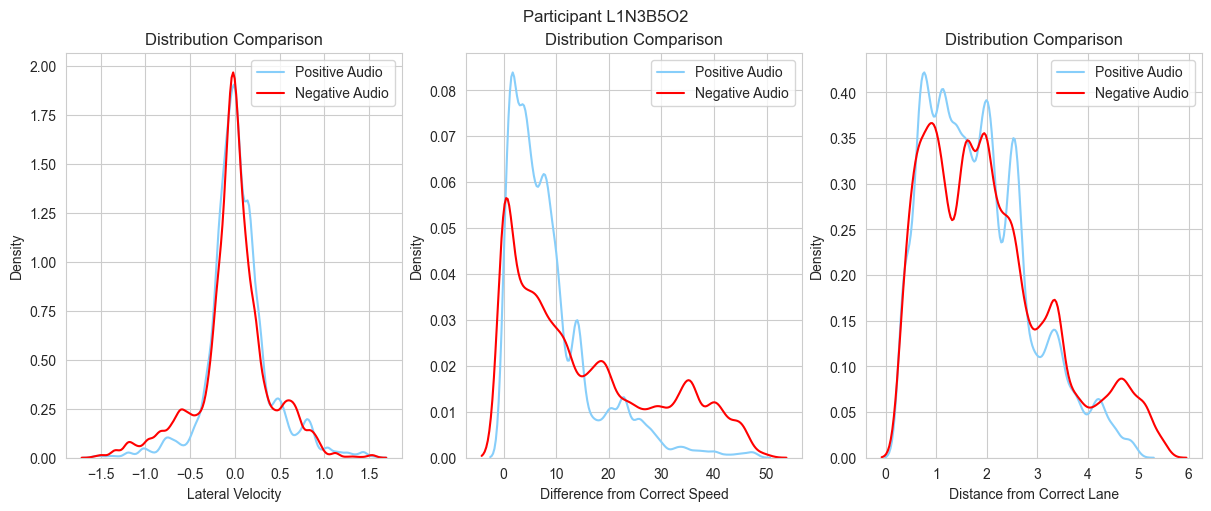

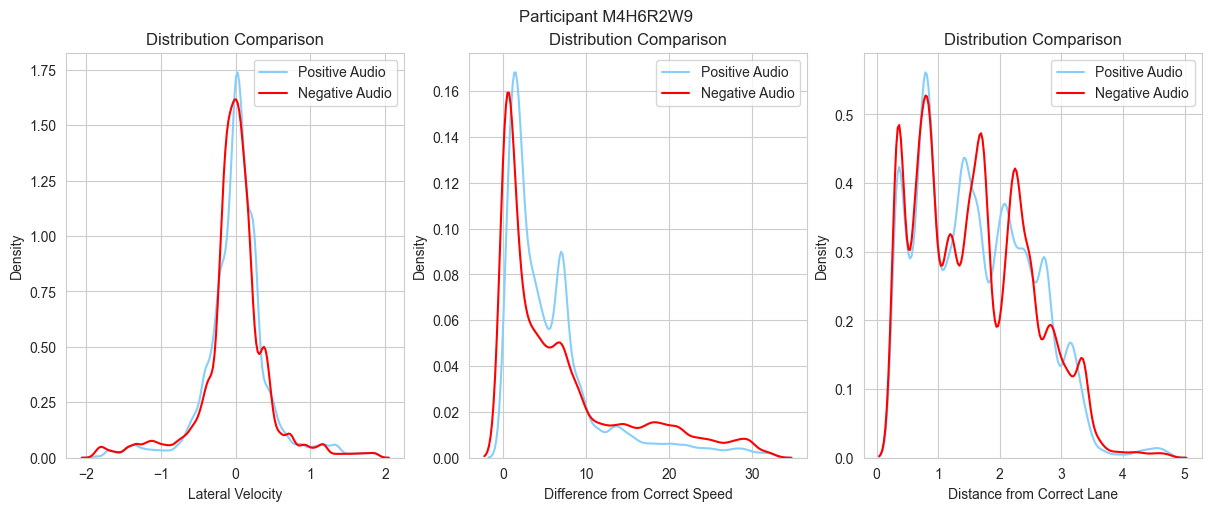

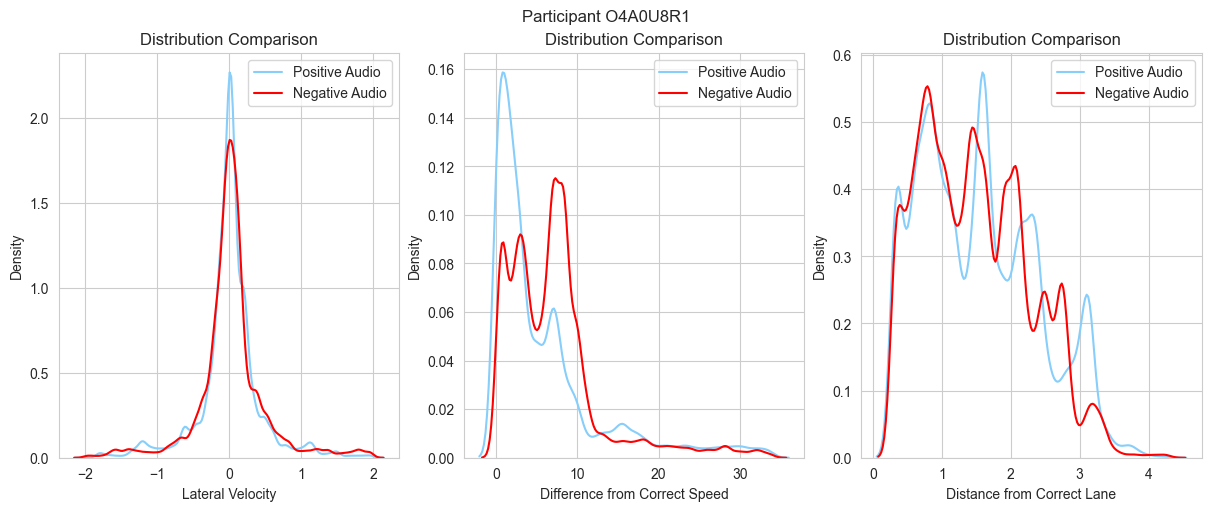

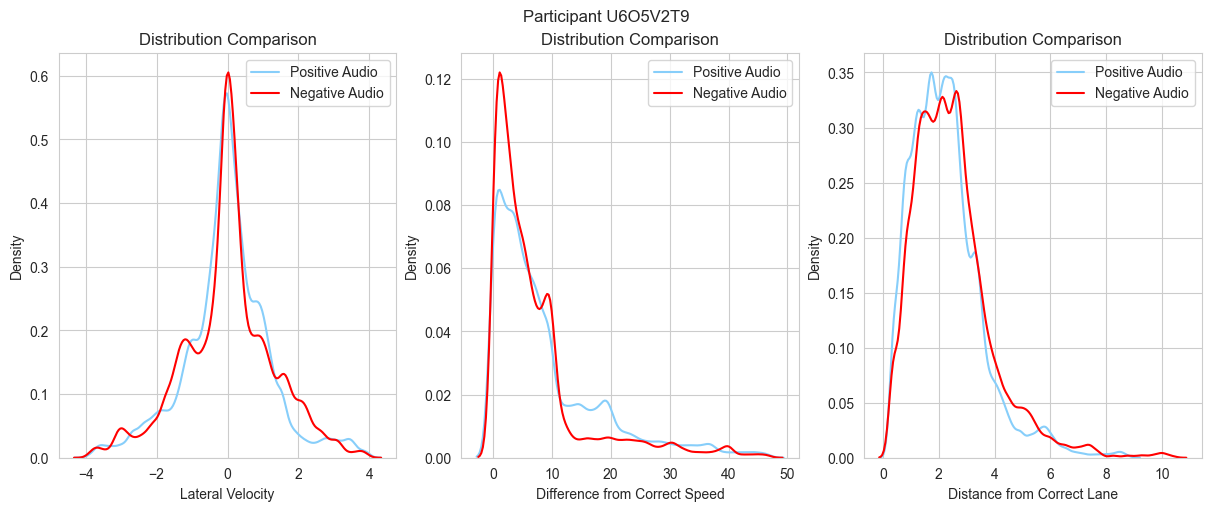

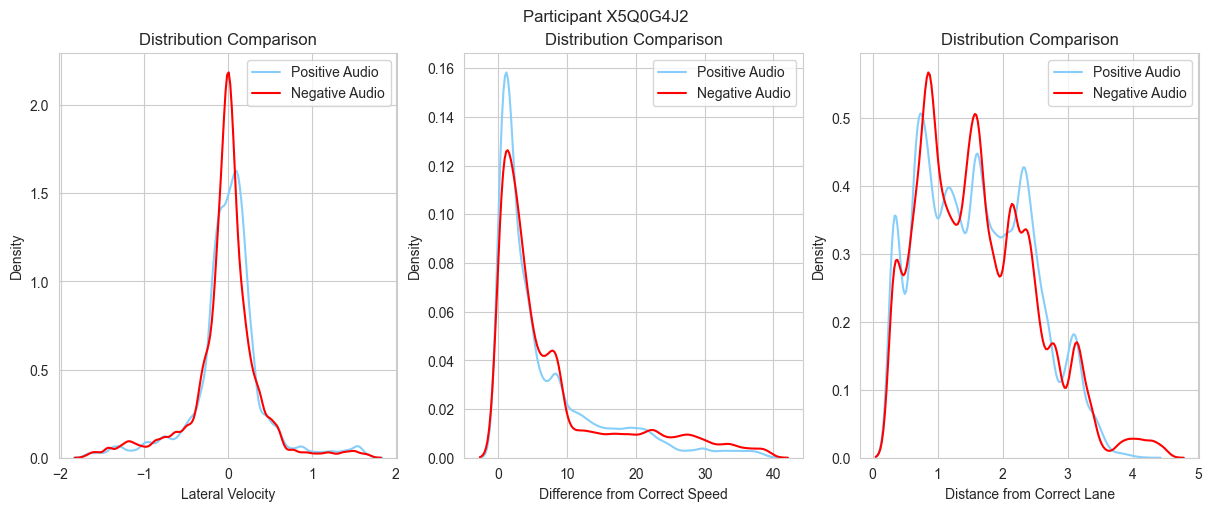

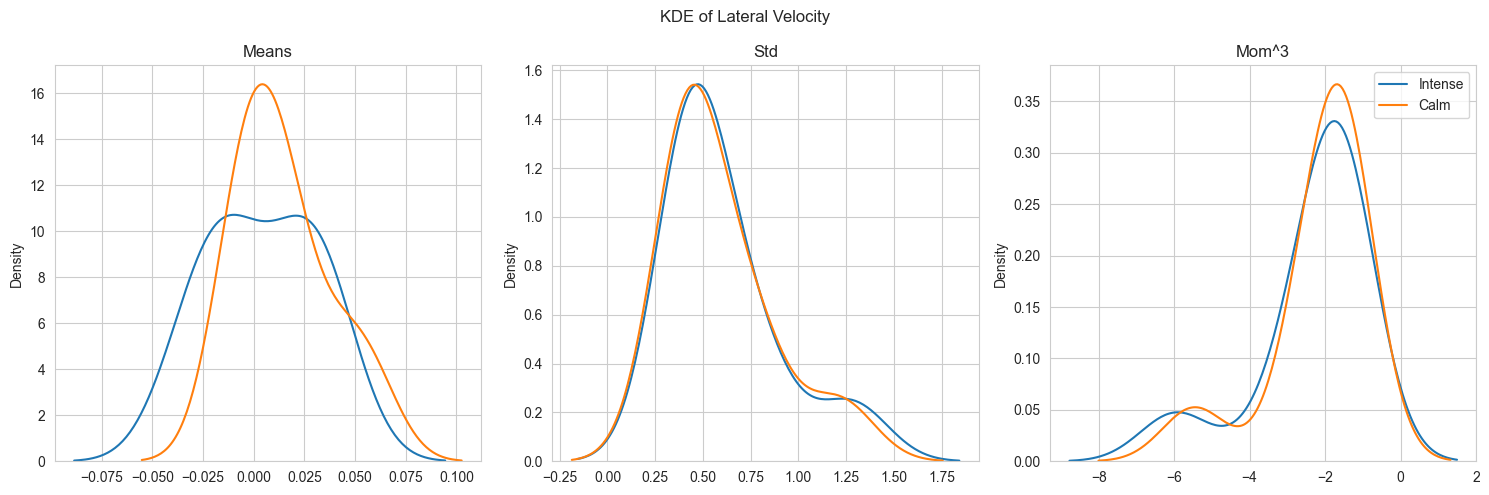

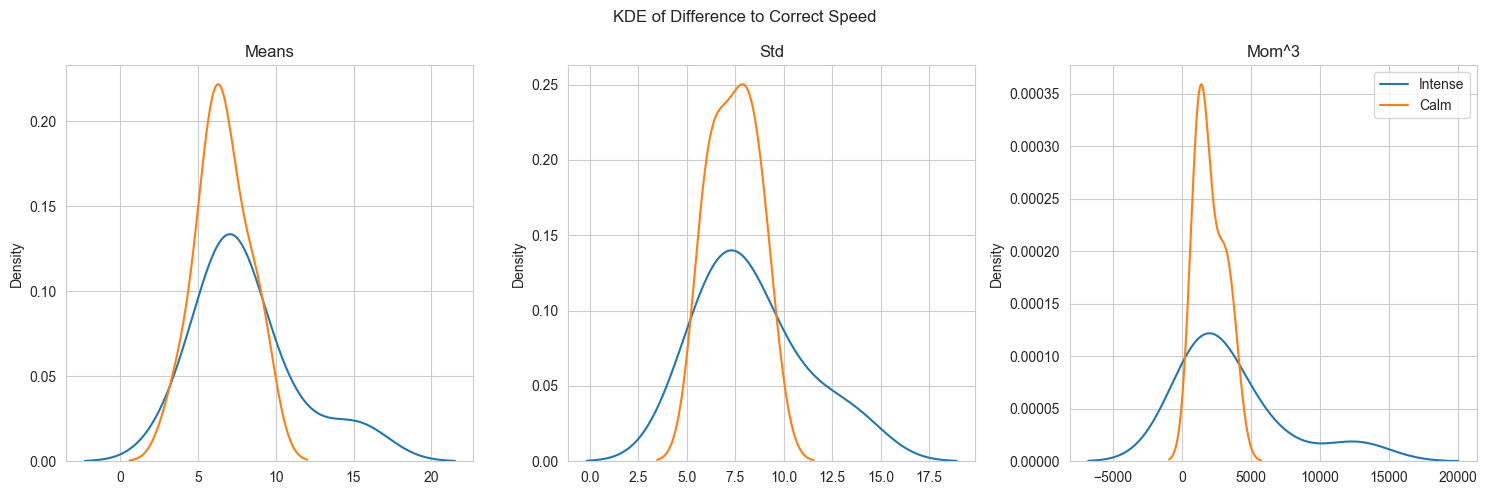

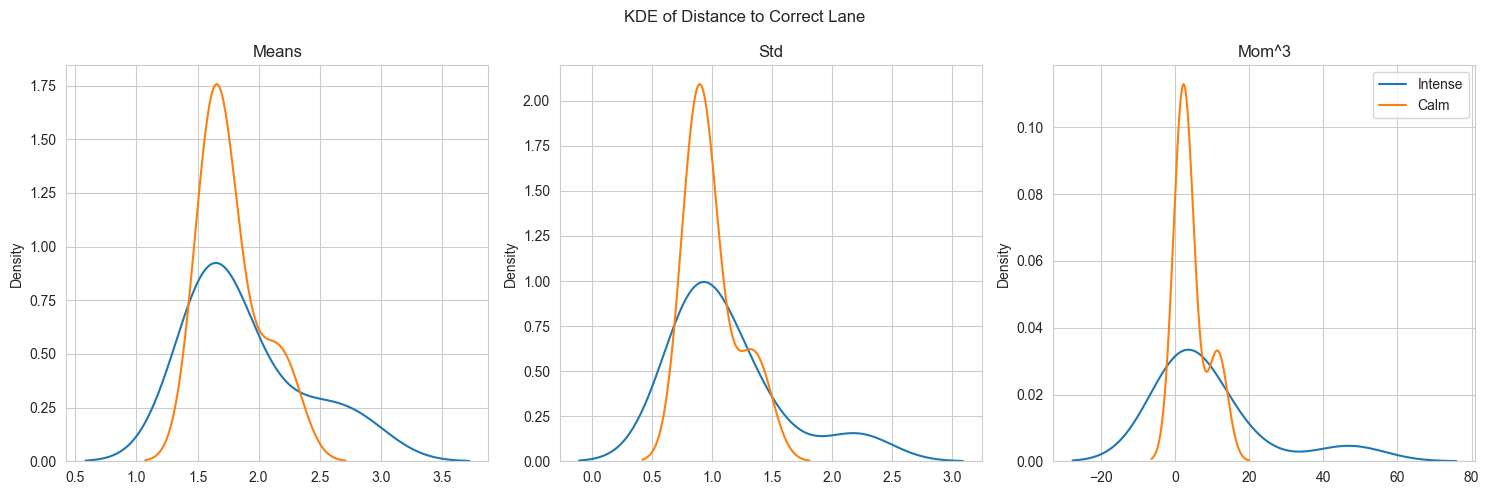

In [ ]:
calm_np, intense_np = get_all_stats(drop_order='PN', remove_outliers=['VelocityX', 'DistanceToTargetPosition', 'DistanceToTargetSpeed'])
dataset_np = generate_datasets(calm_stats=calm_np, intense_stats=intense_np, pairs=pairs)
plot_all_perf_param_kdes(datasets=dataset_np, titles=titles)

In [ ]:
from scipy.stats import kruskal
for j, (intense, calm) in enumerate(dataset_np):
    print(f'\nT-test results for {titles[j]}, intense vs calm:')
    print(f'Means: {ttest_rel([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {ttest_rel([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {ttest_rel([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')
    print(f'\nKruskal results for {titles[j]}, intense vs calm:')
    print(f'Means: {kruskal([x for x,_,_ in intense],[x for x,_,_ in calm]).pvalue}')
    print(f'STDs: {kruskal([x for _,x,_ in intense],[x for _,x,_ in calm]).pvalue}')
    print(f'Mom^3s: {kruskal([x for _,_,x in intense],[x for _,_,x in calm]).pvalue}')


T-test results for Lateral Velocity, intense vs calm:
Means: 0.3556519914590071
STDs: 0.36067970444815245
Mom^3s: 0.12628805976909227

Kruskal results for Lateral Velocity, intense vs calm:
Means: 0.3538369006847303
STDs: 0.6911022238448452
Mom^3s: 0.5659921481957904

T-test results for Difference to Correct Speed, intense vs calm:
Means: 0.08736241398413035
STDs: 0.24327299476592465
Mom^3s: 0.20578670961162954

Kruskal results for Difference to Correct Speed, intense vs calm:
Means: 0.2004110749405393
STDs: 0.6272069263720175
Mom^3s: 0.5659921481957904

T-test results for Distance to Correct Lane, intense vs calm:
Means: 0.20118904874593646
STDs: 0.20083928279739688
Mom^3s: 0.23715261185316996

Kruskal results for Distance to Correct Lane, intense vs calm:
Means: 0.8946258095467479
STDs: 0.8252828980151854
Mom^3s: 0.8252828980151854
